In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
from shapely.geometry import Point
from scipy.stats import fisher_exact
import warnings
import geopandas as gpd
from itertools import combinations

import scipy.stats as stats
from IPython.display import display, clear_output
import ipywidgets as widgets
from IPython.display import display, Markdown
from ipywidgets import interact, widgets, VBox, HBox, HTML, Button

import psycopg2
import seaborn as sns
warnings.filterwarnings("ignore")
import datetime
import unicodedata
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', None)

import geopandas as gpd
from geobr import read_state
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from geobr import read_state
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from geobr import read_state

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geobr import read_state

import pandas as pd

pd.set_option('display.float_format', '{:.2f}'.format)


In [4]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pygeos

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install scikit-learn-extra

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install geopandas matplotlib geobr


Note: you may need to restart the kernel to use updated packages.


# analistas_contratos

In [9]:
conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

cursor.execute(f"""
SELECT 
    f.company_id, 
    f.id AS id_contrato,
    f.start_at as data,
    f.price / 100 AS price,       
    f.contract_days,
    comp.analyst_success_id AS analyst_id, 
    u.name AS analyst
FROM 
    freights f
LEFT JOIN 
    cities c ON f.origin = c.id
JOIN 
    companies comp ON f.company_id = comp.id
JOIN 
    users u ON comp.analyst_success_id = u.id
WHERE 
    f.status = 300
    AND f.start_at > '2023-10-30'
    AND comp.analyst_success_id IS NOT NULL;



""")

analistas_contratos = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
analistas_contratos = pd.DataFrame(analistas_contratos, columns=colnames)

analistas_contratos['data'] = pd.to_datetime(analistas_contratos['data']).dt.to_period('M').dt.to_timestamp()
cols = ['data'] + [col for col in analistas_contratos.columns if col != 'data']
analistas_contratos = analistas_contratos[cols]

analistas_contratos = analistas_contratos.loc[analistas_contratos.data != '2023-10-01']
analistas_contratos = analistas_contratos.loc[analistas_contratos.data != '2024-11-01']
cursor.close()
conn.close()

analistas_contratos.head()

,data,company_id,id_contrato,price,contract_days,analyst_id,analyst
0,2024-09-01,1610,112681,230,1,233,Rafael Fonseca Ramos da Silva
1,2024-09-01,2240,110486,750,2,14,Guilherme Bervalt
2,2024-09-01,1643,112449,705,3,233,Rafael Fonseca Ramos da Silva
3,2024-09-01,1022,107978,2530,11,227,Jonathan Medeiros
4,2024-10-01,2129,114647,4270,14,288,Gloria Trevisani


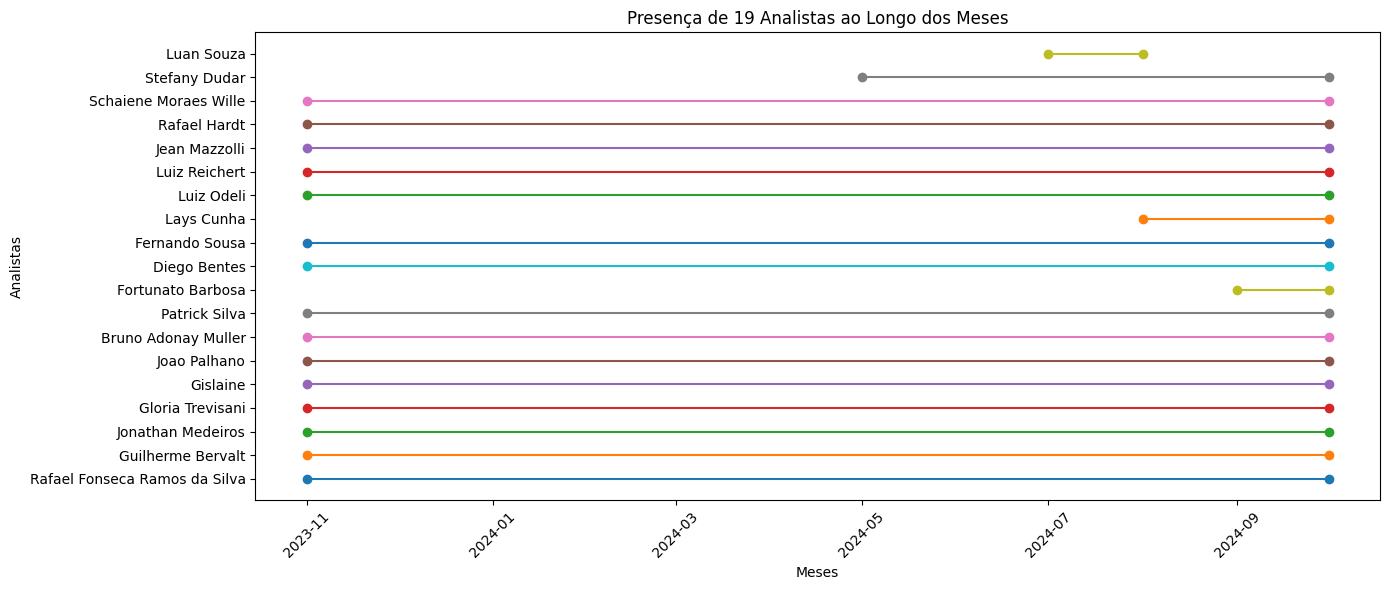

In [10]:
df= analistas_contratos.copy()


# Agora, vamos plotar o gráfico com analistas no eixo Y e meses no formato datetime no eixo X
plt.figure(figsize=(14, 6))

# Iterando sobre os analistas únicos
for analyst in df['analyst'].unique():
    analyst_data = df[df['analyst'] == analyst].sort_values('data')
    
    # Pegando o primeiro e o último mês em que o analista apareceu
    first_month = analyst_data['data'].iloc[0]
    last_month = analyst_data['data'].iloc[-1]
    
    # Plotando uma linha reta entre o primeiro e o último mês
    plt.plot([first_month, last_month], [analyst, analyst], marker='o', markersize=6, label=analyst)

# Ajustando o gráfico
plt.xticks(rotation=45)
plt.xlabel('Meses')
plt.ylabel('Analistas')

# Título com quantidade total de analistas
num_analysts = df['analyst'].nunique()
plt.title(f'Presença de {num_analysts} Analistas ao Longo dos Meses')


plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [11]:

analistas_contagens = analistas_contratos.groupby(['data', 'analyst_id', 'analyst']).agg(
    qt_transportadoras =('company_id', 'nunique'),  # Contagem única de company_id
    qt_contratos=('id_contrato', 'nunique'),  # Contagem única de id_contrato
    total_price=('price', 'sum'), # Soma dos preços
    dias_agenciados=('contract_days', 'sum')
).reset_index()

print('CONTAGEM POR MES')
analistas_contagens.head()


CONTAGEM POR MES


,data,analyst_id,analyst,qt_transportadoras,qt_contratos,total_price,dias_agenciados
0,2023-11-01,14,Guilherme Bervalt,14,122,508781,1765
1,2023-11-01,120,Gislaine,22,370,435875,1762
2,2023-11-01,133,Jean Mazzolli,21,89,247320,833
3,2023-11-01,192,Diego Bentes,16,90,310792,1129
4,2023-11-01,219,Patrick Silva,22,220,879509,2892


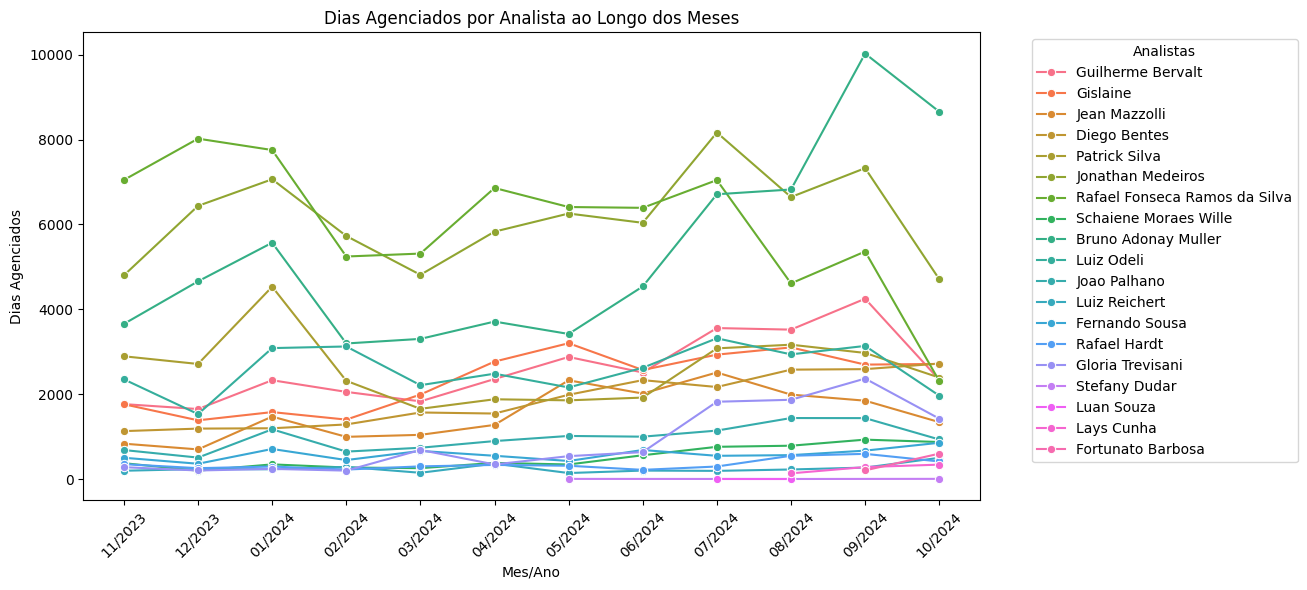

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Criando o DataFrame
df = analistas_contagens.copy()

# Extraindo mês/ano da coluna 'data'
df['mes_ano'] = df['data'].dt.strftime('%m/%Y')

# Criando o gráfico
plt.figure(figsize=(10, 6))

# Criando o lineplot
sns.lineplot(data=df, x='mes_ano', y='dias_agenciados', hue='analyst', marker='o')

# Ajustando o gráfico
plt.xlabel('Mes/Ano')
plt.ylabel('Dias Agenciados')
plt.title('Dias Agenciados por Analista ao Longo dos Meses')
plt.xticks(rotation=45)  # Para melhorar a visualização dos meses
plt.tight_layout()
plt.legend(title='Analistas', bbox_to_anchor=(1.05, 1), loc='upper left')

# Exibindo o gráfico
plt.show()



In [13]:
# Somar os valores de total_price para cada analista
analistas_contagens_sum = analistas_contagens.groupby('analyst')['total_price'].sum().reset_index()

# Ordenar por total_price e pegar os 5 maiores
top_analistas = analistas_contagens_sum.sort_values(by='total_price', ascending=False).head(5)

# Calcular o total geral para calcular a porcentagem
total_price_sum = analistas_contagens_sum['total_price'].sum()

# Calcular a porcentagem de cada analista
top_analistas['percentage'] = (top_analistas['total_price'] / total_price_sum) * 100

top_analistas.percentage.sum()

66.49875919009938

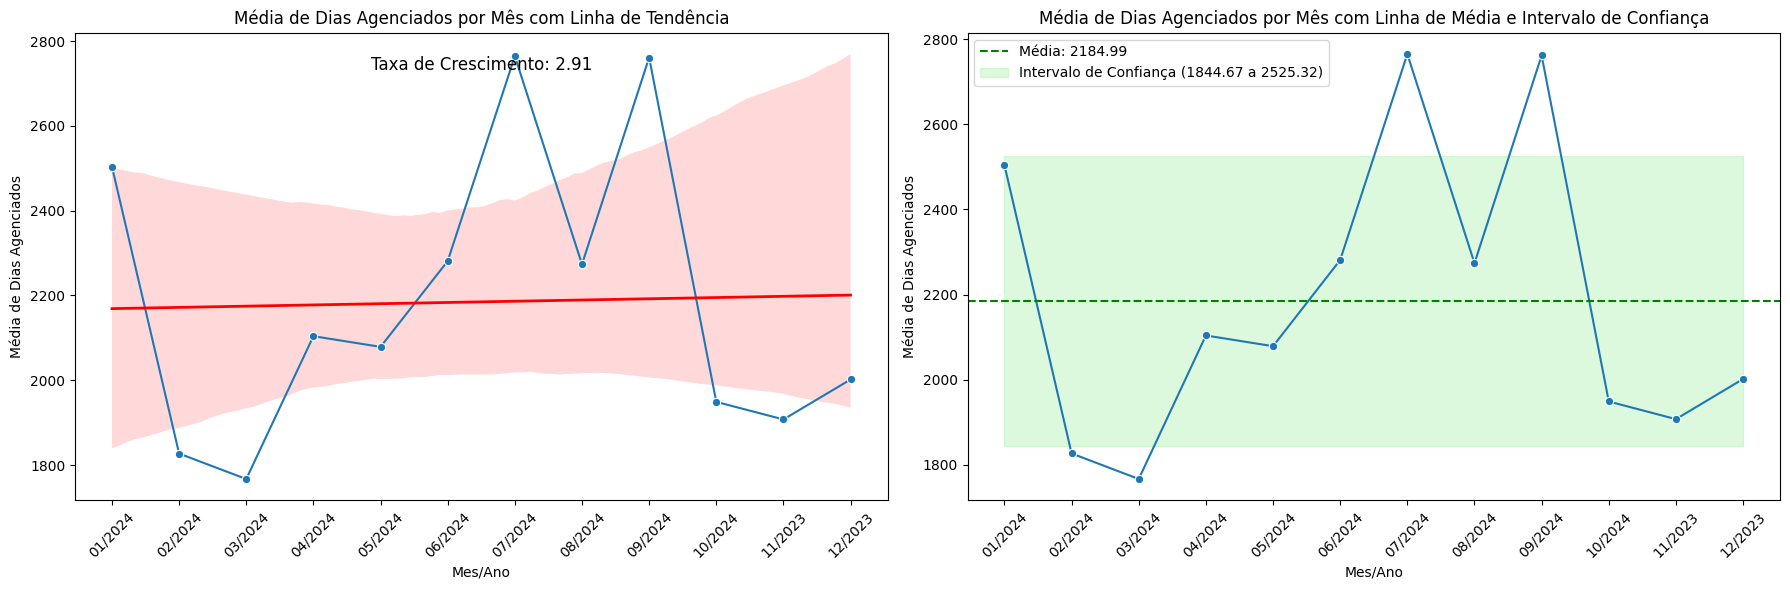

Coeficiente angular (inclinação) da linha de tendência: 2.91


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Supondo que você já tenha o DataFrame 'df' carregado
df = analistas_contagens.copy()

# Extraindo mês/ano da coluna 'data'
df['mes_ano'] = df['data'].dt.strftime('%m/%Y')

# Agrupar por mês e calcular a média de dias agenciados
df_monthly_avg = df.groupby('mes_ano')['dias_agenciados'].mean().reset_index()

# Convertendo os meses para índices numéricos (para regressão linear)
df_monthly_avg['mes_index'] = np.arange(len(df_monthly_avg))

# Regressão linear para calcular a linha de tendência
X = df_monthly_avg['mes_index'].values.reshape(-1, 1)  # A variável independente (índice do mês)
y = df_monthly_avg['dias_agenciados'].values  # A variável dependente (dias_agenciados)

# Ajustando o modelo de regressão linear
regressor = LinearRegression()
regressor.fit(X, y)

# Coeficiente angular (inclinação) e coeficiente linear (interceptação)
coef_angular = regressor.coef_[0]
intercept = regressor.intercept_

# Calculando o intervalo de confiança
media_dias_agenciados = df_monthly_avg['dias_agenciados'].mean()
desvio_padrao = df_monthly_avg['dias_agenciados'].std()
limite_inferior = media_dias_agenciados - desvio_padrao
limite_superior = media_dias_agenciados + desvio_padrao

# Criando o gráfico com 2 subgráficos (lado a lado)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Criar dois gráficos lado a lado

# Gráfico 1 - Com linha de tendência
sns.lineplot(data=df_monthly_avg, x='mes_ano', y='dias_agenciados', marker='o', ax=axes[0])
sns.regplot(data=df_monthly_avg, x=df_monthly_avg['mes_index'], y='dias_agenciados', scatter=False, color='red', line_kws={'linewidth': 2}, ax=axes[0])
axes[0].set_title('Média de Dias Agenciados por Mês com Linha de Tendência')
axes[0].set_xlabel('Mes/Ano')
axes[0].set_ylabel('Média de Dias Agenciados')
axes[0].tick_params(axis='x', rotation=45)

# Exibir taxa de crescimento (coeficiente angular)
axes[0].text(0.5, 0.95, f'Taxa de Crescimento: {coef_angular:.2f}', transform=axes[0].transAxes, ha='center', va='top', fontsize=12, color='black')

# Gráfico 2 - Com linha de média e intervalo de confiança
sns.lineplot(data=df_monthly_avg, x='mes_ano', y='dias_agenciados', marker='o', ax=axes[1])
axes[1].axhline(y=media_dias_agenciados, color='green', linestyle='--', label=f'Média: {media_dias_agenciados:.2f}')
axes[1].fill_between(
    df_monthly_avg['mes_ano'],
    limite_inferior,
    limite_superior,
    color='lightgreen',
    alpha=0.3,
    label=f'Intervalo de Confiança ({limite_inferior:.2f} a {limite_superior:.2f})'
)


axes[1].set_title('Média de Dias Agenciados por Mês com Linha de Média e Intervalo de Confiança')
axes[1].set_xlabel('Mes/Ano')
axes[1].set_ylabel('Média de Dias Agenciados')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

# Ajustando o layout
plt.tight_layout()

# Exibindo os gráficos
plt.show()

# Exibindo o coeficiente angular (inclinação)
print(f'Coeficiente angular (inclinação) da linha de tendência: {coef_angular:.2f}')


O coeficiente angular (inclinação) da linha de tendência, 2.90, indica que, em média, os dias agenciados aumentam aproximadamente 2,90 por mês ao longo do período analisado.

Interpretação detalhada:
O que significa o valor?
A inclinação da linha de tendência reflete a taxa de crescimento mensal dos dias agenciados. Um coeficiente positivo como este significa que há um aumento consistente no valor médio de dias agenciados ao longo do tempo.

Impacto no contexto:

Se a análise é feita ao longo de 12 meses, isso significa que, ao final do período, os dias agenciados médios aumentaram cerca de 
2.90×12=34.8 dias, em comparação com o início.

O crescimento pode ser devido a fatores como maior demanda por serviços, aumento na eficiência operacional, ou entrada de mais contratos.

# ibge

In [15]:
# IBGE - Mesoregioes
ibge = gpd.read_file("BR_Mesorregioes_2022/BR_Mesorregioes_2022.shp").rename(columns={'NM_MESO': 'meso', 'SIGLA_UF': 'estado'})
ibge = ibge[['meso', 'geometry', 'estado']]

## all_meso

In [16]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

def process_monthly_data_range(conn, start_month, end_month, ibge_path):
    """
    Processa dados mensais em um intervalo de meses e realiza junções espaciais com as mesorregiões do IBGE.
    """
    # Gerar lista de meses no intervalo
    all_months = pd.date_range(start=start_month, end=end_month, freq='MS').strftime('%Y-%m').tolist()
    
    # Lista para armazenar os resultados de cada mês
    monthly_results = []
    
    # Loop por cada mês
    for year_month in all_months:
        print(f"Processando dados para {year_month}...")  # Log de progresso
        
        # Step 1: Consultar o banco de dados
        cursor = conn.cursor()
        
        query = f"""
        SELECT 
            f.company_id, 
            f.id AS id_contrato,
            f.driver_id,
            f.start_at as data,
            f.contract_days as dias_agenciados,
            f.price / 100 AS price,
            f.origin AS cidade_origem,
            c.name AS de_cidade_origem,
            c.latitude AS latitude_origem,
            c.longitude AS longitude_origem,
            s.uf AS estado_origem
        FROM 
            freights f
        LEFT JOIN 
            cities c ON f.origin = c.id
        LEFT JOIN 
            states s ON c.state_id = s.id
        WHERE 
            f.status = 300
            AND DATE_TRUNC('month', f.start_at) = '{year_month}-01';
        """
        
        cursor.execute(query)
        results = cursor.fetchall()
        colnames = [desc[0] for desc in cursor.description]
        data = pd.DataFrame(results, columns=colnames)
        cursor.close()
        
        # Step 2: Pré-processar os dados
        data = data.loc[(data['company_id'] != 3) & (data['company_id'] != 4)]  # Excluir empresas 3 e 4
        data['data'] = pd.to_datetime(data['data']).dt.to_period('M').dt.to_timestamp()
        data = data.dropna()  # Remover valores nulos
        data = data[['data', 'company_id', 'id_contrato', 'driver_id', 'dias_agenciados', 'price', 'latitude_origem', 'longitude_origem']]
        
        # Step 3: Carregar os dados IBGE - Mesorregiões
        ibge = gpd.read_file(ibge_path)
        ibge = ibge[['NM_MESO', 'SIGLA_UF', 'geometry']]
        ibge.columns = ['meso', 'estado', 'geometry']  # Renomear colunas
        
        # Step 4: Junção espacial com os dados geográficos
        data['geometry'] = gpd.points_from_xy(data['longitude_origem'], data['latitude_origem'])
        gdf = gpd.GeoDataFrame(data, geometry='geometry', crs=ibge.crs)
        joined = gpd.sjoin(gdf, ibge, how="left", predicate="intersects")
        joined = joined.drop(columns=['latitude_origem', 'longitude_origem', 'index_right', 'geometry'])
        
        # Step 5: Adicionar geometria das mesorregiões
        result = pd.merge(joined, ibge, on=['estado', 'meso'], how='left')
        
        # Step 6: Agregar os dados por data, estado e mesorregião
        aggregated = result.groupby(['data', 'estado', 'meso']).agg(
            qt_contratos=('id_contrato', 'nunique'),
            qt_transportadoras=('company_id', 'nunique'),
            qt_motoristas=('driver_id', 'nunique'),
            dias_agenciados=('dias_agenciados', 'sum'),
            price=('price', 'sum')
        ).reset_index()
        
        # Adicionar aos resultados mensais
        monthly_results.append(aggregated)
    
    # Concatenar todos os resultados em um único DataFrame
    final_result = pd.concat(monthly_results, ignore_index=True)
    return final_result


In [17]:
# Conexão com o banco de dados
import psycopg2

conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)

# Caminho para o shapefile IBGE
ibge_path = "BR_Mesorregioes_2022/BR_Mesorregioes_2022.shp"

# Executar a função para um mês/ano específico
start_month = "2023-10" 
end_month = "2024-10"
all_meso = process_monthly_data_range(conn, start_month, end_month, ibge_path)

# Visualizar o resultado
display(all_meso.head())

# Salvar o resultado em CSV (opcional)
all_meso.to_csv("resultado_mensal.csv", index=False)


Processando dados para 2023-10...
Processando dados para 2023-11...
Processando dados para 2023-12...
Processando dados para 2024-01...
Processando dados para 2024-02...
Processando dados para 2024-03...
Processando dados para 2024-04...
Processando dados para 2024-05...
Processando dados para 2024-06...
Processando dados para 2024-07...
Processando dados para 2024-08...
Processando dados para 2024-09...
Processando dados para 2024-10...


,data,estado,meso,qt_contratos,qt_transportadoras,qt_motoristas,dias_agenciados,price
0,2023-10-01,AL,Agreste Alagoano,4,1,4,108,30240
1,2023-10-01,AL,Leste Alagoano,31,4,21,412,127827
2,2023-10-01,AL,Sertão Alagoano,7,1,5,97,27985
3,2023-10-01,AM,Centro Amazonense,5,2,4,76,20280
4,2023-10-01,AM,Sudoeste Amazonense,37,2,27,668,202641


In [63]:
import pandas as pd
import statsmodels.api as sm

# Supondo que o DataFrame original seja 'dados'
dados = all_meso.copy()

# Converta a coluna 'data' para o formato datetime
dados['data'] = pd.to_datetime(dados['data'])
dados['data_inicio_transportadora'] = pd.to_datetime(dados['data_inicio_transportadora'])

# Calcular a taxa de aumento mensal para 'dias_agenciados' e 'qt_transportadoras'
dados = dados.sort_values(by=['estado', 'meso', 'data'])
dados['dias_agenciados_taxa_aumento'] = dados.groupby(['estado', 'meso'])['dias_agenciados'].pct_change() * 100
dados['qt_transportadoras_taxa_aumento'] = dados.groupby(['estado', 'meso'])['qt_transportadoras'].pct_change() * 100

# Adicionar variáveis de mês e trimestre
dados['mes'] = dados['data'].dt.month
dados['trimestre'] = dados['data'].dt.to_period('Q')

# Calcular o tempo de operação da transportadora em meses
dados['tempo_operacao_transportadora'] = (dados['data'] - dados['data_inicio_transportadora']).dt.days / 30

# Definir variáveis independentes (incluindo mês, transportadoras e tempo de operação) e dependentes (preço)
X = dados[['mes', 'qt_transportadoras', 'dias_agenciados', 'tempo_operacao_transportadora']]
X = sm.add_constant(X)  # Adiciona constante para o modelo
y = dados['price']

# Ajustar o modelo OLS
modelo = sm.OLS(y, X).fit()

# Visualizar os resultados do modelo
print(modelo.summary())

# Prever valores ajustados com base no modelo
dados['predicao_price'] = modelo.predict(X)

# Calcular a média ajustada das taxas de aumento para cada variável
taxas_ajustadas = dados.groupby('estado')[['dias_agenciados_taxa_aumento', 'qt_transportadoras_taxa_aumento']].mean()

# Exibir a média ajustada
print("\nMédia ajustada das taxas de aumento:")
print(taxas_ajustadas)

# Visualizar as primeiras linhas do DataFrame para conferir os cálculos
print("\nDados com taxas de aumento e previsões ajustadas:")
print(dados[['data', 'estado', 'meso', 'dias_agenciados', 'qt_transportadoras', 
             'dias_agenciados_taxa_aumento', 'qt_transportadoras_taxa_aumento', 
             'predicao_price']].head())


KeyError: 'data_inicio_transportadora'

## mensal_estado

In [60]:

contagem_mensal_uf = all_meso.groupby(['data','estado']).agg(
    dias_agenciados =('dias_agenciados', 'sum'),
    qt_contratos=('qt_contratos', 'nunique'),
    qt_motoristas=('qt_motoristas', 'nunique'),
    qt_transportadoras=('qt_transportadoras', 'nunique'),
    price = ('price', 'sum')
).reset_index()


# calculando as medias do ultimo ano
mensal_estado = contagem_mensal_uf.groupby(['estado' ]).agg(
    dias_agenciados=('dias_agenciados', 'mean'),
    contratos=('qt_contratos', 'mean'),
    motoristas=('qt_motoristas', 'mean'),
    transportadoras=('qt_transportadoras', 'mean'),
    price = ('price', 'mean')

).reset_index()

mensal_estado = mensal_estado.sort_values(by='dias_agenciados').reset_index(drop=True)
# mensal_estado['price/contrato'] = mensal_estado['price']/mensal_estado['qt_contratos']
# mensal_estado.to_csv('mensal_estado.csv', index=False)
mensal_estado = mensal_estado.round(2)

print(f"\033[1m Valores mensais do último ano por estado \033[0m")
display(contagem_mensal_uf.head(3))
print()
print(f"\033[1m Médias mensais do último ano por estado \033[0m")
display(mensal_estado.head(3))

 Valores mensais do último ano por estado 


,data,estado,dias_agenciados,qt_contratos,qt_motoristas,qt_transportadoras,price
0,2023-10-01,AL,617,3,3,2,186052
1,2023-10-01,AM,789,3,3,1,232356
2,2023-10-01,AP,41,1,1,1,11480



 Médias mensais do último ano por estado 


,estado,dias_agenciados,contratos,motoristas,transportadoras,price
0,AC,11.10,1.00,1.00,1.00,2361.70
1,MS,68.92,2.00,1.92,1.54,20549.00
2,RR,83.33,1.11,1.11,1.11,18677.44


In [61]:
contagem_mensal_uf

,data,estado,dias_agenciados,qt_contratos,qt_motoristas,qt_transportadoras,price
0,2023-10-01,AL,617,3,3,2,186052
1,2023-10-01,AM,789,3,3,1,232356
2,2023-10-01,AP,41,1,1,1,11480
3,2023-10-01,BA,6113,6,7,4,1756295
4,2023-10-01,CE,690,6,5,3,190405
...,...,...,...,...,...,...,...
290,2024-10-01,RS,3752,6,6,4,1243726
291,2024-10-01,SC,1084,4,4,3,348052
292,2024-10-01,SE,390,2,2,2,109747
293,2024-10-01,SP,2575,12,12,8,744022


## mensal_meso

In [19]:

# contando o numero de comanys, contratos, motoristas, soma de contract_days e soma de price para cada ano_mes, meso, estado e geometry de cada mes
contagem_mensal_meso = all_meso.copy()


# calculando as medias dos ultimos 3 meses
mensal_meso = contagem_mensal_meso.groupby(['estado' , 'meso']).agg(
    dias_agenciados=('dias_agenciados', 'mean'),
    qt_contratos=('qt_contratos', 'mean'),
    qt_motoristas=('qt_motoristas', 'mean'),
    qt_transportadoras=('qt_transportadoras', 'mean'),
    price = ('price', 'mean')
).reset_index()

mensal_meso = mensal_meso.round(2)

mensal_meso = pd.merge(mensal_meso, ibge, on=['estado', 'meso'], how='left')

mensal_meso = mensal_meso.sort_values(by='price').reset_index(drop=True)
mensal_meso.to_csv('mensal_meso.csv', index=False)

print(f"\033[1m Valores mensais do último ano por mesorregião \033[0m")
display(contagem_mensal_meso.head(3))
print()
print(f"\033[1m Médias mensais dos último ano por mesorregião \033[0m")
mensal_meso.head(3)

 Valores mensais do último ano por mesorregião 


,data,estado,meso,qt_contratos,qt_transportadoras,qt_motoristas,dias_agenciados,price
0,2023-10-01,AL,Agreste Alagoano,4,1,4,108,30240
1,2023-10-01,AL,Leste Alagoano,31,4,21,412,127827
2,2023-10-01,AL,Sertão Alagoano,7,1,5,97,27985



 Médias mensais dos último ano por mesorregião 


,estado,meso,dias_agenciados,qt_contratos,qt_motoristas,qt_transportadoras,price,geometry
0,MS,Pantanais Sul Mato-grossense,1.50,1.00,1.00,1.00,385.00,"POLYGON ((-55.39900 -18.58209, -55.44207 -19.0..."
1,GO,Noroeste Goiano,8.50,4.50,2.50,1.00,1819.00,"POLYGON ((-49.79187 -14.30565, -49.79155 -14.3..."
2,ES,Litoral Norte Espírito-santense,10.00,1.00,1.00,1.00,1940.00,"MULTIPOLYGON (((-40.12458 -18.48854, -40.12470..."


## Matriz de correlação

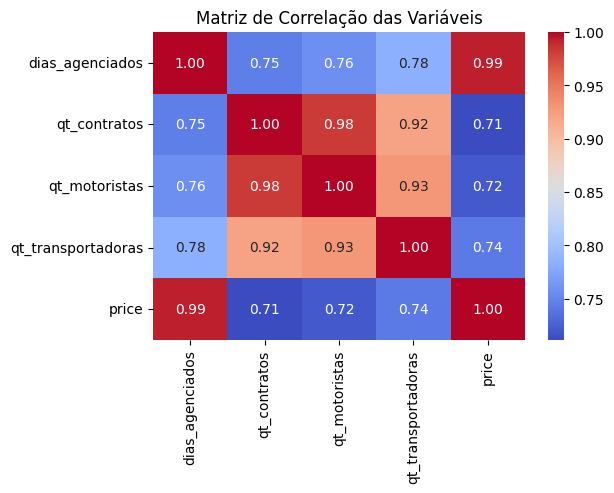

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['dias_agenciados', 'qt_contratos', 'qt_motoristas', 'qt_transportadoras', 'price']

# Calcular a matriz de correlação
corr_matrix = contagem_mensal_uf[num_cols].corr()

# Plotar o heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlação das Variáveis")
plt.show()



A escolha de dias agenciados e número de transportadoras como critérios para a distribuição das mesorregiões em carteiras é fundamentada em uma análise de correlação e impacto operacional. Dias agenciados representa diretamente a intensidade de trabalho ou o volume de operação em cada mesorregião, refletindo o esforço necessário para atender a demanda. Esse critério é um bom indicador de carga de trabalho, crucial para balancear as carteiras de forma eficiente, garantindo que as mesorregiões com maior volume de operação recebam a atenção adequada.

Além disso, ao incluir número de transportadoras, conseguimos incorporar uma variável que reflete a complexidade e diversidade operacional de cada mesorregião. Com uma correlação de 0,92 entre o número de contratos e o número de transportadoras, essa variável está intimamente relacionada ao volume de trabalho, mas também oferece uma visão mais ampla sobre a quantidade de parceiros logísticos envolvidos, o que é crucial para entender a diversidade de operações e os custos associados.

A combinação desses dois critérios permite uma distribuição equilibrada e estratégica, considerando tanto o volume operacional quanto a diversidade logística de cada mesorregião, o que resulta em carteiras mais ajustadas às necessidades reais de cada área. Assim, garantimos uma alocação eficiente e sustentável de recursos, alinhada aos objetivos operacionais da organização.

## distribuição das métricas por estado

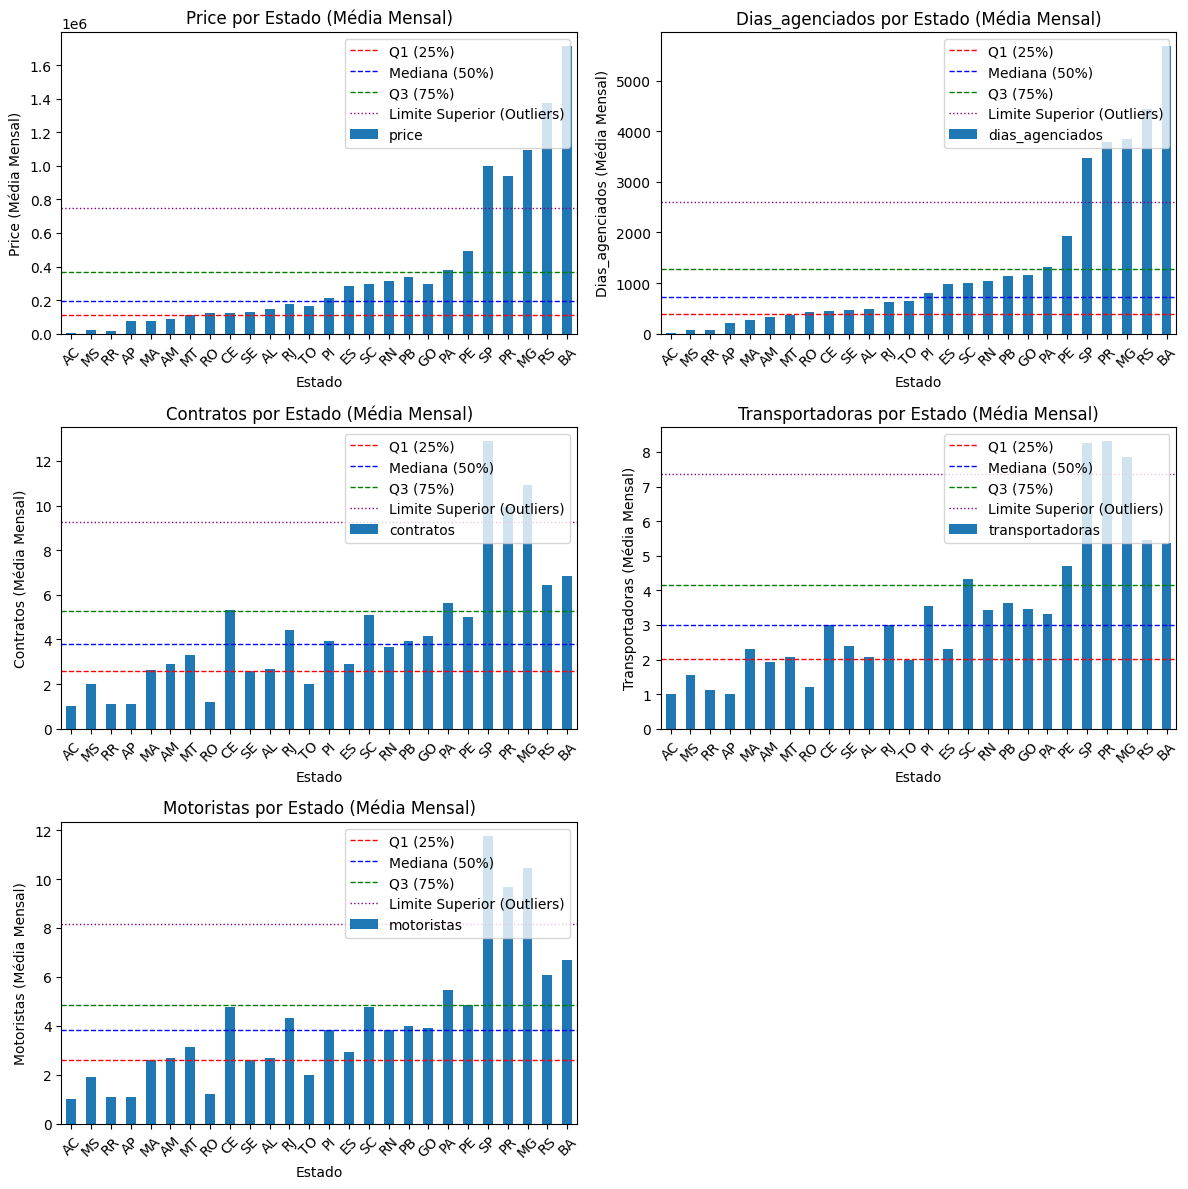

In [21]:
# distribuição dos estados originais

metricas = ['price', 'dias_agenciados', 'contratos', 'transportadoras', 'motoristas']


fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Tamanho ajustado
axes = axes.flatten()  # Transformar em lista para iterar facilmente


for i, metrica in enumerate(metricas):
    # Calcular os quartis e o IQR para a métrica
    q1 = mensal_estado[metrica].quantile(0.25)
    q2 = mensal_estado[metrica].median()
    q3 = mensal_estado[metrica].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

  
    mensal_estado.plot(
        x='estado',
        y=metrica,
        kind='bar',
        ax=axes[i],  # Selecionar o eixo correspondente
        title=f'{metrica.capitalize()} por Estado (Média Mensal)'
    )

    # Adicionar linhas horizontais para Q1, Q2 (mediana), Q3 e limites de outliers
    axes[i].axhline(q1, color='red', linestyle='--', linewidth=1, label='Q1 (25%)')
    axes[i].axhline(q2, color='blue', linestyle='--', linewidth=1, label='Mediana (50%)')
    axes[i].axhline(q3, color='green', linestyle='--', linewidth=1, label='Q3 (75%)')

    axes[i].axhline(upper_bound, color='purple', linestyle=':', linewidth=1, label='Limite Superior (Outliers)')

    # Configurações adicionais
    axes[i].set_ylabel(f'{metrica.capitalize()} (Média Mensal)')
    axes[i].set_xlabel('Estado')
    axes[i].tick_params(axis='x', rotation=45)  # Rotação nos rótulos
    axes[i].legend(loc='upper right')  # Adicionar legenda


for j in range(len(metricas), len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()


# Distribuição geográfica

In [28]:
mensal_estado.head()

,estado,dias_agenciados,contratos,motoristas,transportadoras,price
0,AC,11.10,1.00,1.00,1.00,2361.70
1,MS,68.92,2.00,1.92,1.54,20549.00
2,RR,83.33,1.11,1.11,1.11,18677.44
3,AP,208.60,1.10,1.10,1.00,73484.10
4,MA,274.46,2.62,2.62,2.31,76266.23


# DISTRIBUIÇÃO GEOGRÁFICA

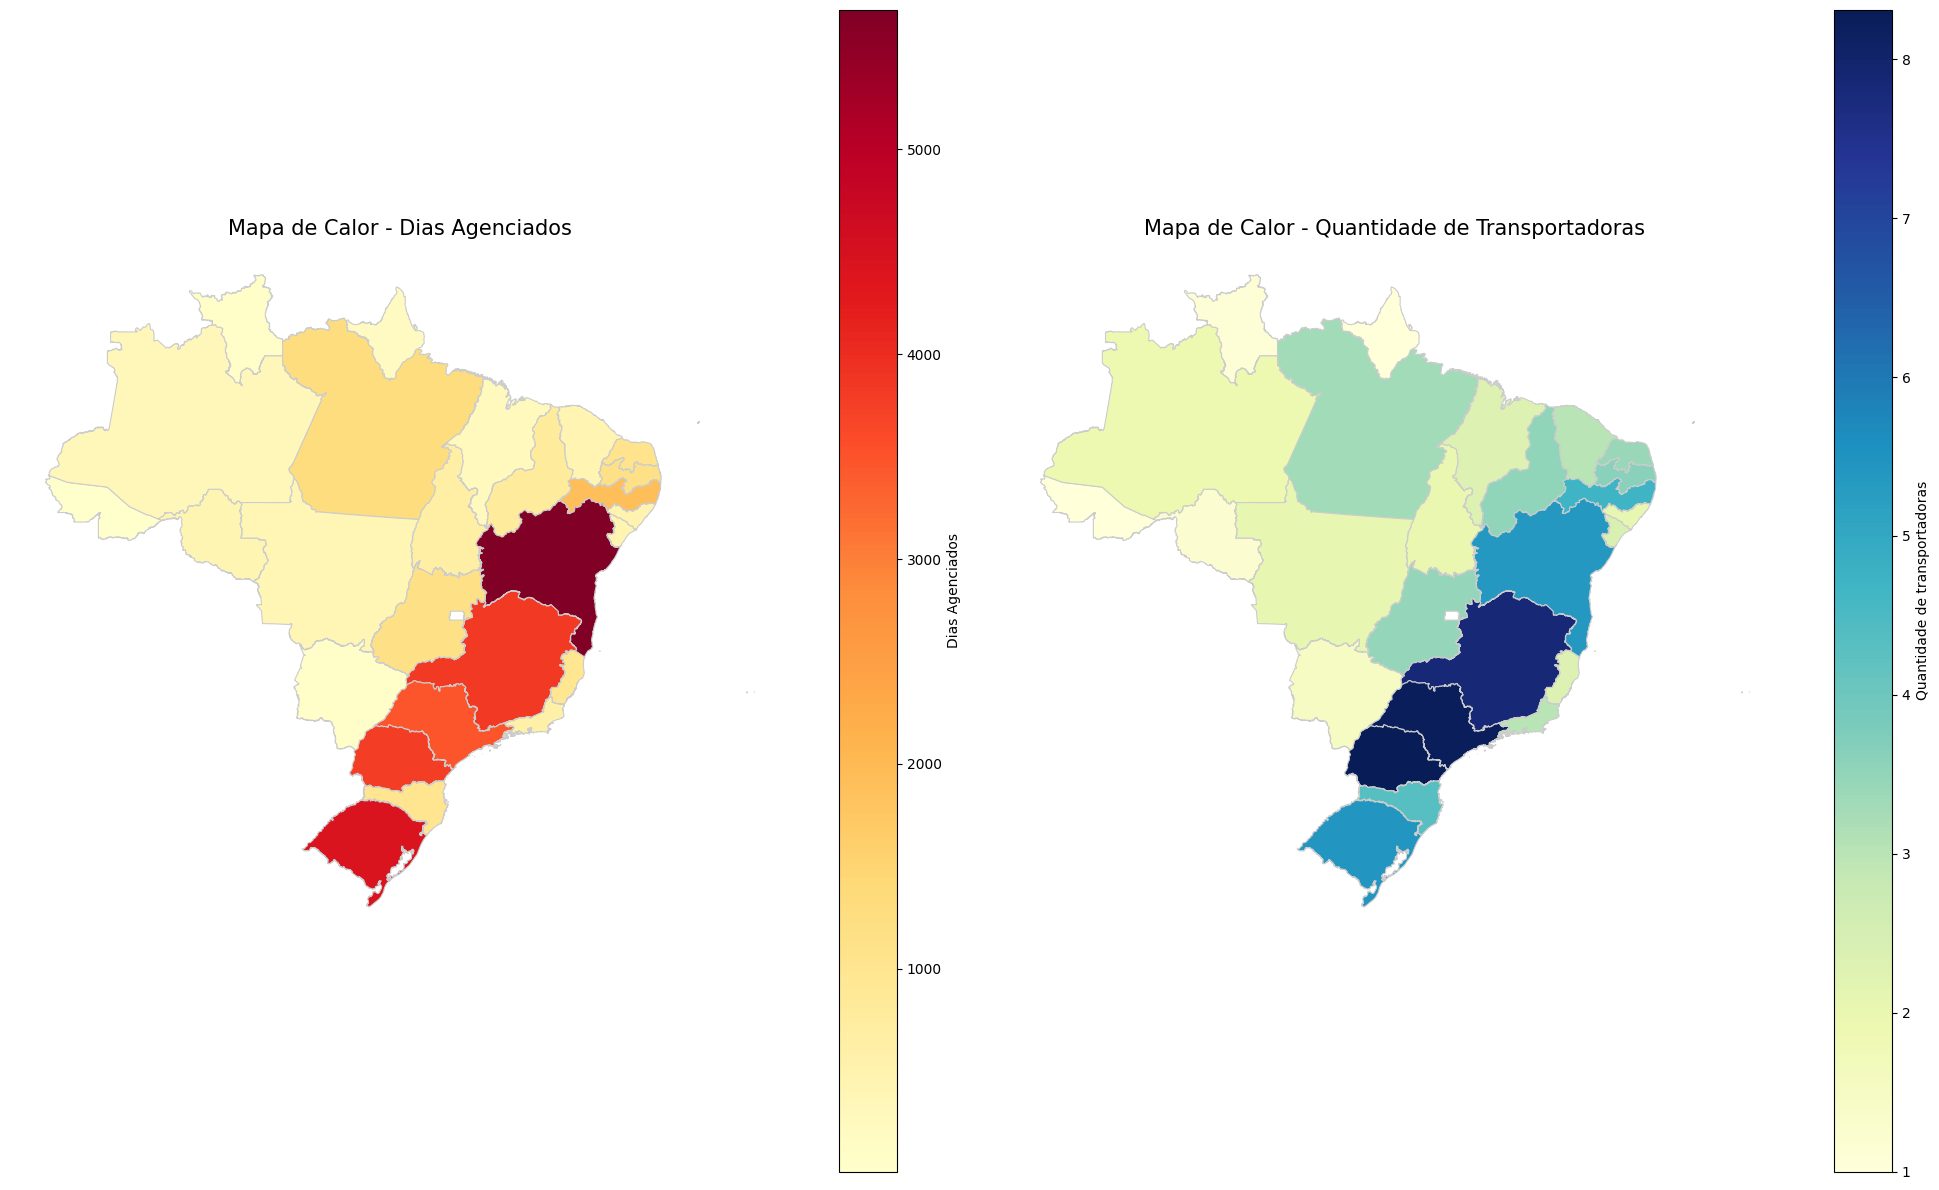

In [41]:
from geobr import read_state

# Carregar a geometria dos estados do Brasil
states_gdf = read_state(year=2020)

# Unir os dados dos estados com as geometrias
states_gdf = states_gdf.merge(mensal_estado, left_on="abbrev_state", right_on="estado")

# Criar subplots para dois mapas de calor
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 linha, 2 colunas

# Mapa de calor para 'dias_agenciados'
states_gdf.plot(
    column="dias_agenciados",
    cmap="YlOrRd",
    linewidth=0.8,
    ax=axes[0],
    edgecolor="0.8",
    legend=True,
    legend_kwds={'label': "Dias Agenciados"}
)
axes[0].set_title("Mapa de Calor - Dias Agenciados", fontsize=15)
axes[0].axis("off")

# Mapa de calor para 'dias_agenciados'
states_gdf.plot(
    column="transportadoras",
    cmap="YlGnBu",
    linewidth=0.8,
    ax=axes[1],
    edgecolor="0.8",
    legend=True,
    legend_kwds={'label': "Quantidade de transportadoras"}
)
axes[1].set_title("Mapa de Calor - Quantidade de Transportadoras", fontsize=15)
axes[1].axis("off")

# Ajustar layout e exibir os gráficos
plt.tight_layout()
plt.show()

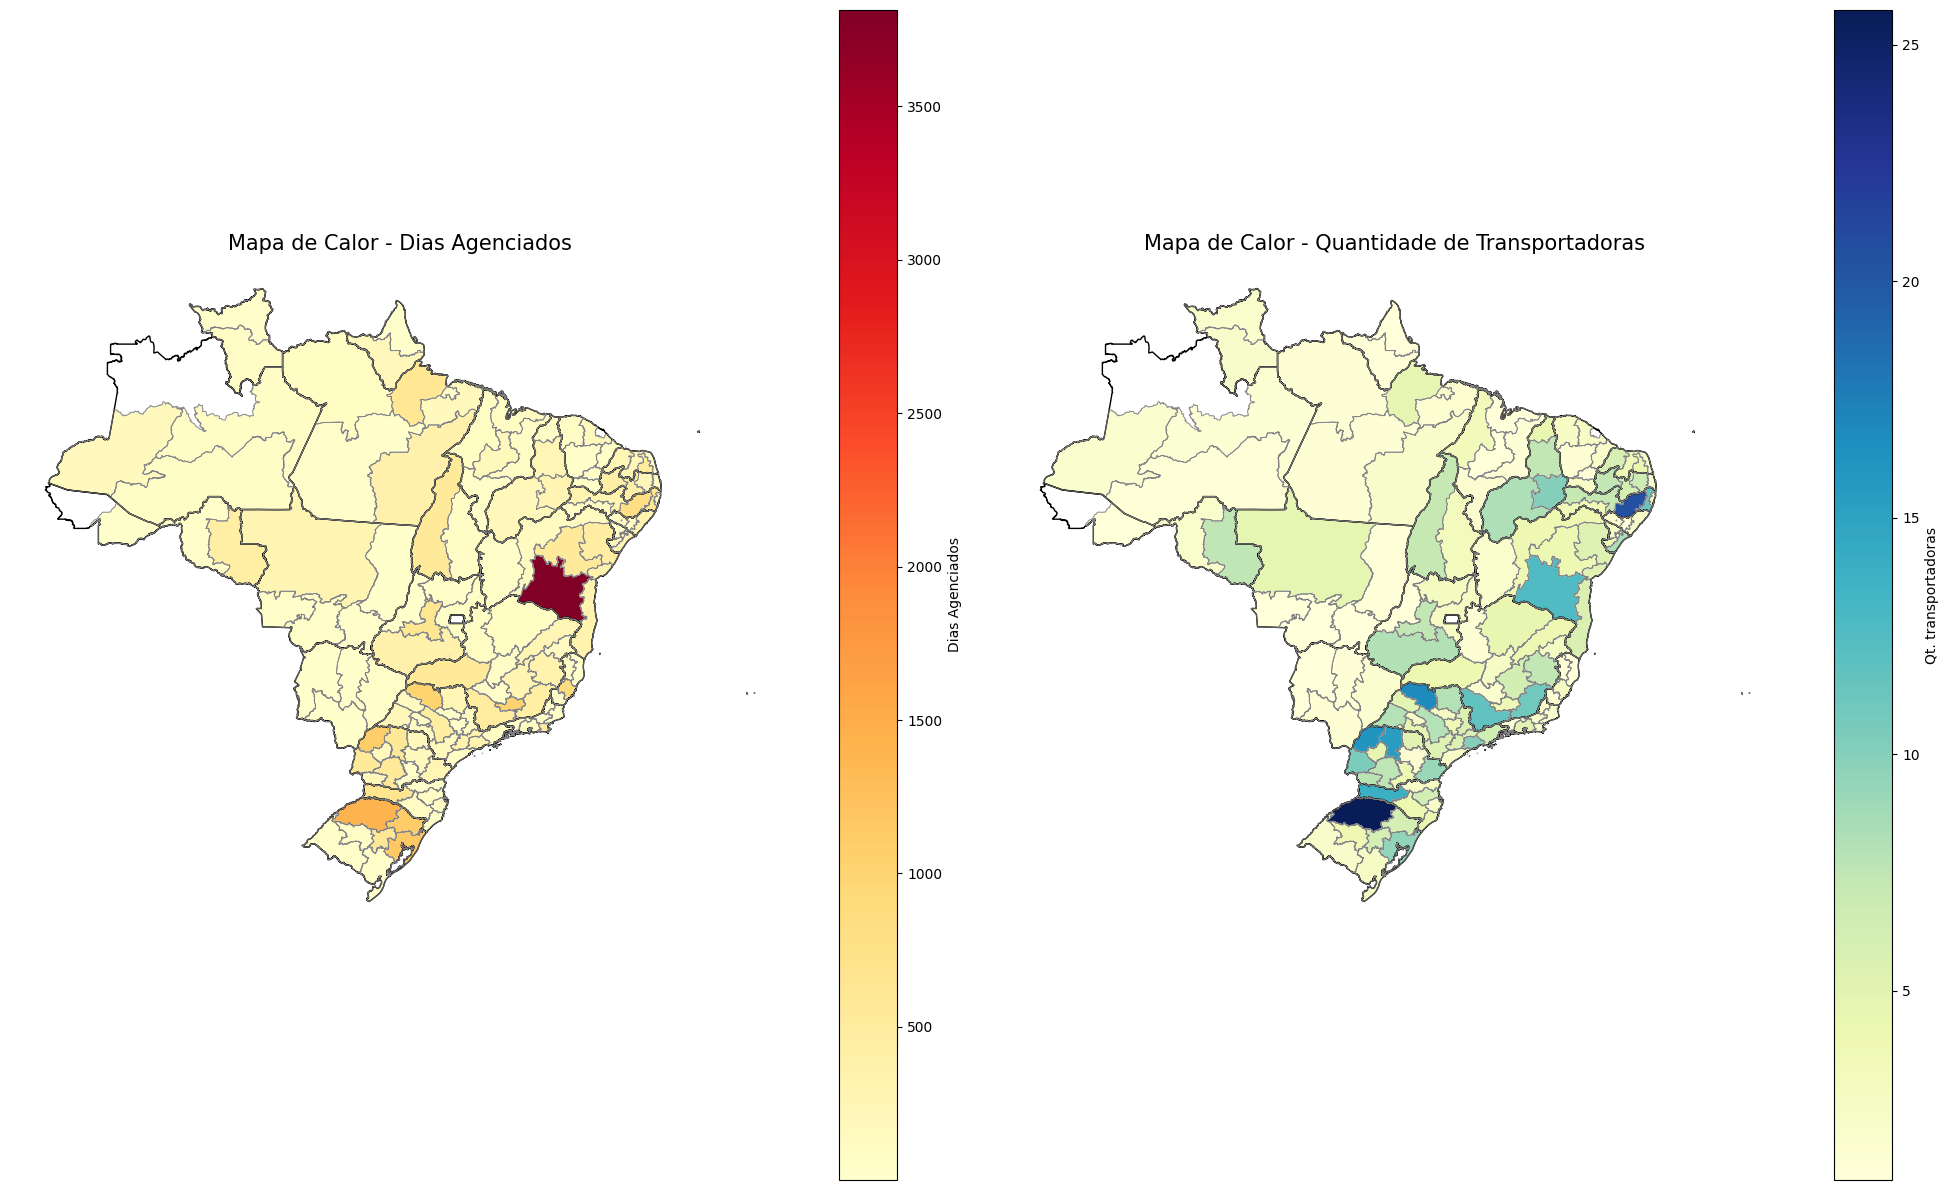

In [50]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from geobr import read_state

# Load the CSV file
file_path = 'mensal_meso.csv'  # Certifique-se de fornecer o caminho correto do arquivo
mensal_meso_updated = pd.read_csv(file_path)

# Convert 'geometry' column from WKT strings to Shapely geometries
mensal_meso_updated['geometry'] = mensal_meso_updated['geometry'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
gdf_mesorregioes = gpd.GeoDataFrame(mensal_meso_updated, geometry='geometry')

# Load Brazilian states shapefile using geobr
states_gdf = read_state(year=2020)

# Create subplots for two heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 row, 2 columns

# Heatmap for 'price' (first map)
gdf_mesorregioes.plot(
    column='dias_agenciados',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=axes[0],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': 'Dias Agenciados'}
)
axes[0].set_title('Mapa de Calor - Dias Agenciados', fontsize=15)
axes[0].axis('off')

# Heatmap for 'dias_agenciados' (second map)
gdf_mesorregioes.plot(
    column='qt_transportadoras',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=axes[1],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': 'Qt. transportadoras'}
)
axes[1].set_title('Mapa de Calor - Quantidade de Transportadoras', fontsize=15)
axes[1].axis('off')

# Plot state boundaries for both maps
states_gdf.boundary.plot(ax=axes[0], color='black', linewidth=1)  # Adjusted line width for better visibility
states_gdf.boundary.plot(ax=axes[1], color='black', linewidth=1)

# Plot mesoregion boundaries for both maps for additional clarity
gdf_mesorregioes.boundary.plot(ax=axes[0], color='gray', linewidth=0.5)
gdf_mesorregioes.boundary.plot(ax=axes[1], color='gray', linewidth=0.5)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# CAIXEIRO VIAJANTE

In [51]:
import pandas as pd
from geopy.distance import geodesic
import networkx as nx
from shapely.geometry import Polygon, MultiPolygon

# Função para calcular a distância entre duas coordenadas (centroide)
def calc_distance(coord1, coord2):
    return geodesic(coord1, coord2).km

# Função para obter o centroide de um polígono
def get_centroid(polygon):
    return polygon.centroid.x, polygon.centroid.y

# Criar o DataFrame de exemplo (ajustar com seus dados)
pcv = mensal_meso[['estado', 'meso', 'geometry', 'dias_agenciados']]
df = pcv.copy()

# Criar um gráfico onde cada mesorregião é um nó
G = nx.complete_graph(len(df))

# Definir as distâncias entre as mesorregiões como peso das arestas
for i in range(len(df)):
    for j in range(i+1, len(df)):
        # Obter o centroide das mesorregiões
        coord1 = get_centroid(df['geometry'][i])
        coord2 = get_centroid(df['geometry'][j])
        
        # Calcular a distância
        dist = calc_distance(coord1, coord2)
        
        # Adicionar a distância como peso das arestas
        G[i][j]['weight'] = dist
        G[j][i]['weight'] = dist

# Encontrar a mesorregião de 'Sudeste Rio-grandense'
start_node_index = df[df['meso'] == 'Sudeste Rio-grandense'].iloc[0].name

# Resolver o TSP sem o parâmetro 'start' (iniciaremos manualmente)
# Obtendo a ordem de visita e começando pela mesorregião do RS
tsp_path = nx.approximation.traveling_salesman_problem(G, cycle=False, weight='weight')

# Reorganizando a ordem para começar pela mesorregião de RS
start_index = tsp_path.index(start_node_index)
tsp_path = tsp_path[start_index:] + tsp_path[:start_index]

# Exibir a ordem das mesorregiões no caminho TSP
tsp_order = df.iloc[tsp_path].reset_index(drop=True)

# Adicionar uma coluna de numeração indicando a sequência do caminho TSP
tsp_order['num_sequence'] = tsp_order.index + 1

# Exibir o caminho TSP
print("Caminho TSP com numeração:")
display(tsp_order[['num_sequence', 'estado', 'meso', 'geometry']].head(3))

# Ajustar o TSP com a alocação de analistas
dias_target = 2185  # Definir o limite de dias por analista
analista_counter = 1  # Iniciar com o primeiro analista
total_dias = tsp_order.loc[0, 'dias_agenciados']  # Total de dias do analista atual
used_regions = [False] * len(tsp_order)  # Lista para marcar as regiões já atribuídas a um analista

# Atribuir analistas às mesorregiões (agora priorizando a soma total de dias)
analista_list = [analista_counter]
dias_acumulados = [total_dias]  # Lista para armazenar o total acumulado de dias por analista
used_regions[0] = True  # A primeira região já foi usada

for i in range(1, len(tsp_order)):
    total_dias += tsp_order.loc[i, 'dias_agenciados']
    
    # Se a soma acumulada de dias ultrapassar o limite (mais de 10%)
    if total_dias > dias_target * 1.1:
        # Realocar para a próxima região mais próxima sem ultrapassar o limite
        found = False
        for j in range(i + 1, len(tsp_order)):
            if used_regions[j]:
                continue  # Pular se a região já foi usada

            # Tentar adicionar a próxima região
            new_total_dias = total_dias + tsp_order.loc[j, 'dias_agenciados']
            if new_total_dias <= dias_target * 1.1 and new_total_dias >= dias_target * 0.9:
                # Se a soma fica entre 90% e 110%, alocar a região
                total_dias = new_total_dias
                analista_list.append(analista_counter)
                dias_acumulados.append(total_dias)
                used_regions[j] = True
                found = True
                break

        if not found:
            # Se não encontrou, mudar para o próximo analista
            analista_counter += 1
            total_dias = tsp_order.loc[i, 'dias_agenciados']  # Reinicia a contagem de dias com a nova mesorregião
            analista_list.append(analista_counter)
            dias_acumulados.append(total_dias)
            used_regions[i] = True  # Marcar a região como usada
    else:
        # Se a soma acumulada não ultrapassar o limite, continua com o analista atual
        analista_list.append(analista_counter)
        dias_acumulados.append(total_dias)

tsp_order['analista'] = analista_list

# Agrupar por analista e somar os dias agenciados
total_por_analista = tsp_order.groupby('analista', as_index=False).agg({
    'dias_agenciados': 'sum'
})

# Exibir os totais por analista
print("Totais por analista:")
display(total_por_analista)


Caminho TSP com numeração:


,num_sequence,estado,meso,geometry
0,1,RS,Sudeste Rio-grandense,"(POLYGON ((-52.622885 -32.145571, -52.624273 -..."
1,2,RS,Metropolitana de Porto Alegre,"(POLYGON ((-51.2719 -30.038972, -51.271924 -30..."
2,3,RS,Nordeste Rio-grandense,"POLYGON ((-51.616802 -29.377885, -51.616049 -2..."


Totais por analista:


,analista,dias_agenciados
0,1,2328.74
1,2,2107.14
2,3,2043.85
3,4,2317.04
4,5,2185.57
5,6,2340.11
6,7,2334.43
7,8,2075.94
8,9,3812.92
9,10,2356.69


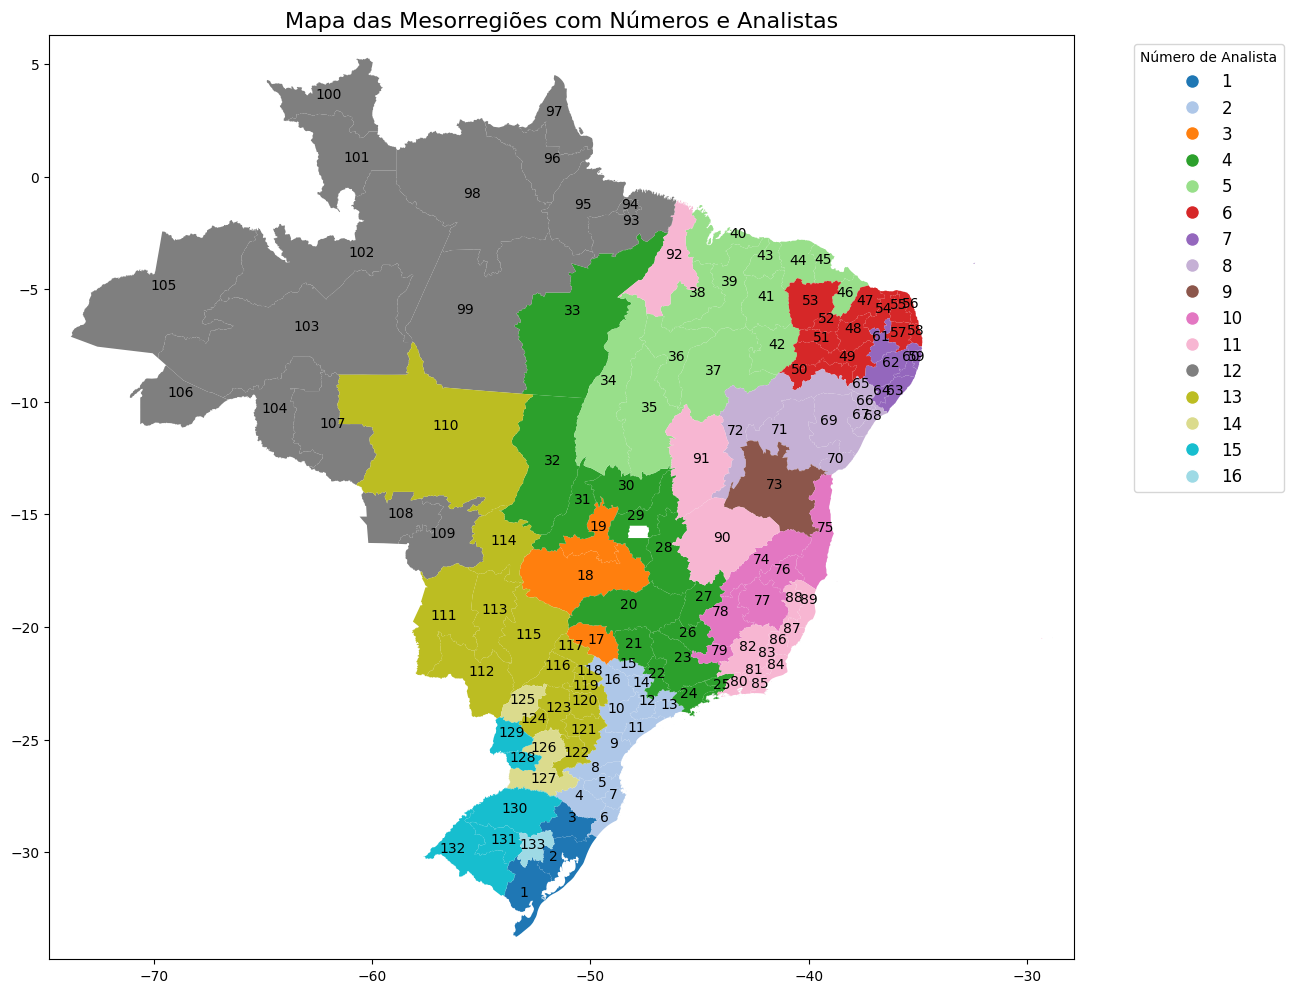

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Garantir que tsp_order seja um GeoDataFrame com geometria válida
if not isinstance(tsp_order, gpd.GeoDataFrame):
    tsp_order = gpd.GeoDataFrame(tsp_order, geometry='geometry')

# Garantir o CRS correto
tsp_order = tsp_order.set_crs("EPSG:4326", allow_override=True)

# Criar um mapa do Brasil
fig, ax = plt.subplots(figsize=(20, 12))

# Criar uma paleta de cores com base no número de analistas únicos
unique_analistas = tsp_order['analista'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_analistas))  # Usando uma paleta de 20 cores

# Plotar as mesorregiões coloridas de acordo com o analista
tsp_order.plot(ax=ax, column='analista', cmap=colors, legend=False)

# Adicionar a legenda manualmente
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors(i), markersize=10) 
           for i in range(len(unique_analistas))]
labels = [str(analista) for analista in unique_analistas]

ax.legend(handles, labels, title="Número de Analista", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adicionar os números dentro de cada mesorregião
for i, row in tsp_order.iterrows():
    # Pega o ponto representativo da geometria
    point = row['geometry'].representative_point()
    lat, lon = point.y, point.x  # Acessa as coordenadas do ponto representativo
    ax.text(lon, lat, str(row['num_sequence']), fontsize=10, ha='center', color='black')  # Número dentro do polígono

# Ajustar os limites do mapa de acordo com os dados
x_min, y_min, x_max, y_max = tsp_order.total_bounds
ax.set_xlim([x_min - 1, x_max + 1])
ax.set_ylim([y_min - 1, y_max + 1])

# Título
plt.title('Mapa das Mesorregiões com Números e Analistas', fontsize=16)

# Exibir o mapa
plt.show()





## distribuição mapa

In [24]:
def dividindo_top_estados(df, state_col, meso_col, target_cols):

    grouped_data = []

    # Iterar sobre os estados únicos
    for state in df[state_col].unique():
        state_data = df[df[state_col] == state]
        
        group_1 = []
        group_2 = []
        group_1_totals = {col: 0 for col in target_cols}
        group_2_totals = {col: 0 for col in target_cols}

        state_data_sorted = state_data.sort_values(by=target_cols[0], ascending=False)

        # Dividir mesorregiões entre os dois grupos
        for _, row in state_data_sorted.iterrows():
            if sum(group_1_totals.values()) <= sum(group_2_totals.values()):
                group_1.append(row)
                for col in target_cols:
                    group_1_totals[col] += row[col]
            else:
                group_2.append(row)
                for col in target_cols:
                    group_2_totals[col] += row[col]

        # Adicionar resultados ao grupo final
        for row in group_1:
            grouped_data.append({**row.to_dict(), 'group_id': 1})
        for row in group_2:
            grouped_data.append({**row.to_dict(), 'group_id': 2})

    # Construir DataFrame final
    grouped_df = pd.DataFrame(grouped_data)
    return grouped_df


# Carregar os dados de mesorregiões dos estados principais
top_estados = mensal_meso[mensal_meso['estado'].isin(['SP', 'MG', 'RS', 'BA', 'PR'])]

# Aplicar a função para dividir os estados
meso_total = dividindo_top_estados(
    top_estados, 
    state_col='estado', 
    meso_col='meso', 
    target_cols=['qt_contratos', 'price']
)

# Resumo por grupo e estado
meso_resumo = meso_total.groupby(['estado', 'group_id'])[['qt_contratos', 'price']].sum().reset_index()
meso_resumo['estado'] = meso_resumo['estado'].astype(str) + meso_resumo['group_id'].astype(str)
meso_resumo = meso_resumo.drop(columns=['group_id'])

# Exibir os resultados
print("Resumo dos totais por grupo e estado:")
print('meso_resumo')
display(meso_resumo)

print("Resumo detalhado por mesorregião:")
meso_total['estado'] = meso_total['estado'].astype(str) + meso_total['group_id'].astype(str)
meso_total = meso_total.drop(columns=['group_id'])
print("meso_total")
display(meso_total)

Resumo dos totais por grupo e estado:
meso_resumo


,estado,qt_contratos,price
0,BA1,171.62,1175820.15
1,BA2,185.38,536333.00
2,MG1,199.19,545717.44
3,MG2,217.12,554136.77
4,PR1,769.53,479349.85
5,PR2,432.30,461370.30
6,RS1,195.40,665834.46
7,RS2,111.64,714900.18
8,SP1,182.86,501231.92
9,SP2,250.77,520476.69


Resumo detalhado por mesorregião:
meso_total


,estado,meso,dias_agenciados,qt_contratos,qt_motoristas,qt_transportadoras,price,geometry
0,RS1,Noroeste Rio-grandense,1409.82,117.55,84.82,25.73,438221.00,"POLYGON ((-53.0167519139999 -29.155679731, -53..."
1,RS1,Centro Oriental Rio-grandense,600.64,43.27,34.09,6.18,186115.27,"POLYGON ((-52.0460455462042 -29.0577078495701,..."
2,RS1,Centro Ocidental Rio-grandense,67.00,24.91,9.73,3.91,15715.64,"POLYGON ((-54.040129825 -29.9174479549999, -54..."
3,RS1,Sudeste Rio-grandense,52.56,4.89,4.44,2.67,15265.22,(POLYGON ((-52.6228848621048 -32.1455712488285...
4,RS1,Sudoeste Rio-grandense,41.22,4.78,4.11,2.22,10517.33,"POLYGON ((-54.701293901 -31.4356677919999, -54..."
5,RS2,Metropolitana de Porto Alegre,1159.18,60.64,52.36,9.55,384453.09,"(POLYGON ((-51.271899645 -30.03897208, -51.271..."
6,RS2,Nordeste Rio-grandense,1117.00,51.00,42.45,6.18,330447.09,"POLYGON ((-51.6168022771846 -29.3778849840343,..."
7,MG1,Zona da Mata,439.85,80.85,40.77,11.00,115294.08,"POLYGON ((-42.1744937519999 -21.131777546, -42..."
8,MG1,Campo das Vertentes,1029.23,57.08,42.85,3.77,315801.00,"POLYGON ((-44.163559 -21.589391996, -44.163673..."
9,MG1,Noroeste de Minas,97.73,19.64,10.73,1.45,26403.82,"POLYGON ((-46.76082 -18.308766997, -46.761313 ..."


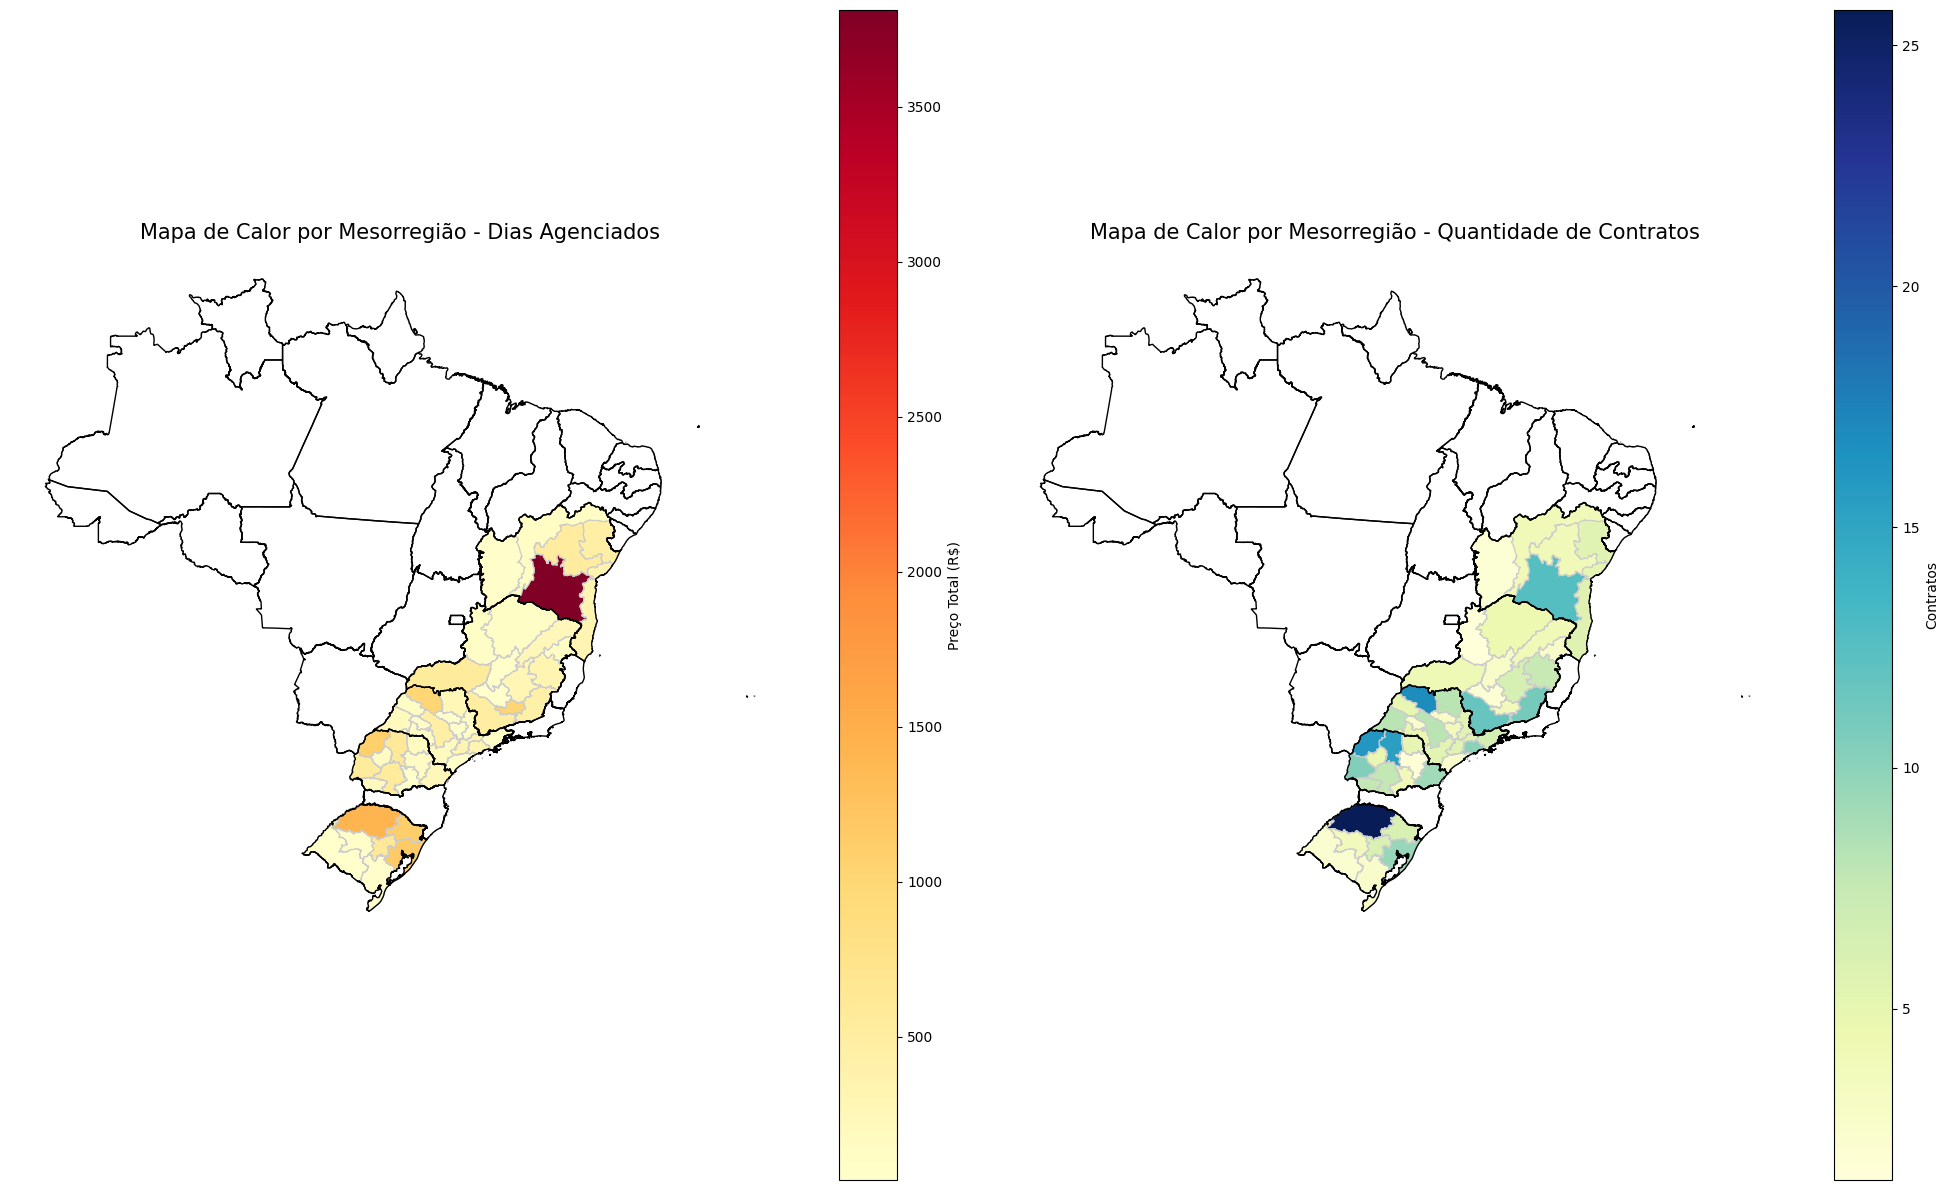

In [25]:
# Dados fornecidos
data = meso_total.copy()

# Criar DataFrame e converter geometria de WKT para Shapely
df = pd.DataFrame(data)

# Garantir que a coluna 'geometry' seja string antes de aplicar wkt.loads
df['geometry'] = df['geometry'].astype(str).apply(wkt.loads)

# Converter para GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Carregar o shapefile dos estados (ajuste conforme necessário)
states_gdf = read_state(year=2020)

# Criar subplots para mapas lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 linha, 2 colunas

# Mapa de calor para 'price'
gdf.plot(
    column='dias_agenciados',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=axes[0],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Preço Total (R$)"}
)
# Plot dos estados sobre o mapa de preço
states_gdf.plot(
    ax=axes[0],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[0].set_title('Mapa de Calor por Mesorregião - Dias Agenciados', fontsize=15)
axes[0].axis('off')

# Mapa de calor para 'dias_agenciados'
gdf.plot(
    column='qt_transportadoras',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=axes[1],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Contratos"}
)
# Plot dos estados sobre o mapa de dias agenciados
states_gdf.plot(
    ax=axes[1],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[1].set_title('Mapa de Calor por Mesorregião - Quantidade de Contratos', fontsize=15)
axes[1].axis('off')

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()


In [26]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

# Dados fornecidos
data = meso_total.copy()

# Criar DataFrame
df = pd.DataFrame(data)

# Garantir que a coluna 'geometry' seja string e converter para Shapely
df['geometry'] = df['geometry'].astype(str).apply(wkt.loads)

# Converter para GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Agrupar por estado, somar colunas numéricas e unir as geometrias
gdf_grouped = gdf.dissolve(
    by='estado',
    aggfunc={
        'dias_agenciados': 'sum',
        'contratos': 'sum',
        'motoristas': 'sum',
        'transportadoras': 'sum',
        'price': 'sum'
    }
)

# Carregar o shapefile dos estados (ajuste conforme necessário)
states_gdf = read_state(year=2020)

# Criar subplots para mapas lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 linha, 2 colunas

# Mapa de calor para 'price'
gdf_grouped.plot(
    column='price',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=axes[0],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Preço Total (R$)"}
)
# Plot dos estados sobre o mapa de preço
states_gdf.plot(
    ax=axes[0],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[0].set_title('Mapa de Calor por Estado - Preço Total dos Contratos', fontsize=15)
axes[0].axis('off')

# Mapa de calor para 'dias_agenciados'
gdf_grouped.plot(
    column='dias_agenciados',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=axes[1],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Dias Agenciados"}
)
# Plot dos estados sobre o mapa de dias agenciados
states_gdf.plot(
    ax=axes[1],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[1].set_title('Mapa de Calor por Estado - Dias Agenciados', fontsize=15)
axes[1].axis('off')

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()


KeyError: "Column(s) ['contratos', 'motoristas', 'transportadoras'] do not exist"

## ic_top_estados

In [ ]:
# Função para calcular o intervalo de confiança
def calcular_ic(coluna, nivel_confianca=0.95):
    media = coluna.mean()
    erro_padrao = stats.sem(coluna)
    intervalo = stats.t.interval(nivel_confianca, len(coluna) - 1, loc=media, scale=erro_padrao)
    return media, intervalo[0], intervalo[1]

# Colunas para as quais calcular IC
colunas = ['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']

# Calcular IC para cada coluna
resultados = []
for coluna in colunas:
    media, limite_inferior, limite_superior = calcular_ic(meso_resumo[coluna])
    resultados.append({
        'Coluna': coluna,
        'IC Inferior': limite_inferior,
        'Média': media,    
        'IC Superior': limite_superior
    })

# Criar DataFrame com os resultados
ic_top_estados = pd.DataFrame(resultados)

# Exibir a tabela
ic_top_estados


## estados_dividos

In [ ]:
estado_para_concat = mensal_estado[['estado', 'contratos', 'price', 'dias_agenciados','transportadoras', 'motoristas']]

# Filtrar 'estado' para eliminar os estados específicos
estado_filtrado = estado_para_concat[~estado_para_concat['estado'].isin(['SP', 'MG', 'RS', 'BA', 'PR', 'PE'])]

# Concatenar com group_totals
estados_divididos = pd.concat([estado_filtrado, meso_resumo], ignore_index=True)

# Exibir o DataFrame concatenado
estados_divididos


In [ ]:


fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Tamanho ajustado
axes = axes.flatten()  # Transformar em lista para iterar facilmente


for i, metrica in enumerate(metricas):
    # Calcular os quartis e o IQR para a métrica
    q1 = estados_divididos[metrica].quantile(0.25)
    q2 = estados_divididos[metrica].median()
    q3 = estados_divididos[metrica].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

  
    estados_divididos.plot(
        x='estado',
        y=metrica,
        kind='bar',
        ax=axes[i],  # Selecionar o eixo correspondente
        title=f'{metrica.capitalize()} por Estado (Média Mensal)'
    )

    # Adicionar linhas horizontais para Q1, Q2 (mediana), Q3 e limites de outliers
    axes[i].axhline(q1, color='red', linestyle='--', linewidth=1, label='Q1 (25%)')
    axes[i].axhline(q2, color='blue', linestyle='--', linewidth=1, label='Mediana (50%)')
    axes[i].axhline(q3, color='green', linestyle='--', linewidth=1, label='Q3 (75%)')

    axes[i].axhline(upper_bound, color='purple', linestyle=':', linewidth=1, label='Limite Superior (Outliers)')

    # Configurações adicionais
    axes[i].set_ylabel(f'{metrica.capitalize()} (Média Mensal)')
    axes[i].set_xlabel('Estado')
    axes[i].tick_params(axis='x', rotation=45)  # Rotação nos rótulos
    axes[i].legend(loc='upper right')  # Adicionar legenda


for j in range(len(metricas), len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()


# juntando estados menos ativos

In [ ]:
ic_top_estados

In [ ]:
menores = estados_divididos[['estado', 'contratos','price', 'dias_agenciados', 'transportadoras', 'motoristas']]

# Seleção das linhas para as regiões Norte, Nordeste, Centro-Oeste e Sudeste
linhas_selecionadas_norte = menores[menores['estado'].isin(['AC', 'AM', 'AP', 'RO', 'RR', 'PA'])]
linhas_selecionadas_nordeste = menores[menores['estado'].isin(['AL', 'CE', 'MA', 'PB', 'PI', 'RN','SE'])]
linhas_selecionadas_centro_oeste = menores[menores['estado'].isin(['GO', 'MS', 'MT','TO'])]
linhas_selecionadas_sudeste = menores[menores['estado'].isin(['ES', 'RJ'])]

# Somando as colunas selecionadas para a região Norte
soma_norte = linhas_selecionadas_norte[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_norte = linhas_selecionadas_norte['estado'].tolist()
estado_somado_norte = ', '.join(estados_norte)

# Somando as colunas selecionadas para a região Nordeste
soma_nordeste = linhas_selecionadas_nordeste[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_nordeste = linhas_selecionadas_nordeste['estado'].tolist()
estado_somado_nordeste = ', '.join(estados_nordeste)

# Somando as colunas selecionadas para a região Centro-Oeste
soma_centro_oeste = linhas_selecionadas_centro_oeste[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_centro_oeste = linhas_selecionadas_centro_oeste['estado'].tolist()
estado_somado_centro_oeste = ', '.join(estados_centro_oeste)

# Somando as colunas selecionadas para a região Sudeste (ES e RJ)
soma_sudeste = linhas_selecionadas_sudeste[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_sudeste = linhas_selecionadas_sudeste['estado'].tolist()
estado_somado_sudeste = ', '.join(estados_sudeste)

# Criando dicionários para as novas linhas
nova_linha_norte = {
    'estado': estado_somado_norte,
    'contratos': soma_norte['contratos'],
    'price': soma_norte['price'],
    'dias_agenciados': soma_norte['dias_agenciados'],
    'transportadoras': soma_norte['transportadoras'],
    'motoristas': soma_norte['motoristas']
}

nova_linha_nordeste = {
    'estado': estado_somado_nordeste,
    'contratos': soma_nordeste['contratos'],
    'price': soma_nordeste['price'],
    'dias_agenciados': soma_nordeste['dias_agenciados'],
    'transportadoras': soma_nordeste['transportadoras'],
    'motoristas': soma_nordeste['motoristas']
}

nova_linha_centro_oeste = {
    'estado': estado_somado_centro_oeste,
    'contratos': soma_centro_oeste['contratos'],
    'price': soma_centro_oeste['price'],
    'dias_agenciados': soma_centro_oeste['dias_agenciados'],
    'transportadoras': soma_centro_oeste['transportadoras'],
    'motoristas': soma_centro_oeste['motoristas']
}

nova_linha_sudeste = {
    'estado': estado_somado_sudeste,
    'contratos': soma_sudeste['contratos'],
    'price': soma_sudeste['price'],
    'dias_agenciados': soma_sudeste['dias_agenciados'],
    'transportadoras': soma_sudeste['transportadoras'],
    'motoristas': soma_sudeste['motoristas']
}

# Convertendo os dicionários em DataFrames
nova_linha_norte_df = pd.DataFrame([nova_linha_norte])
nova_linha_nordeste_df = pd.DataFrame([nova_linha_nordeste])
nova_linha_centro_oeste_df = pd.DataFrame([nova_linha_centro_oeste])
nova_linha_sudeste_df = pd.DataFrame([nova_linha_sudeste])

# Concatenando as novas linhas na tabela original
menores = pd.concat([menores, nova_linha_norte_df, nova_linha_nordeste_df, nova_linha_centro_oeste_df, nova_linha_sudeste_df], ignore_index=True)

# Excluindo as linhas selecionadas das regiões Norte, Nordeste, Centro-Oeste e Sudeste
menores = menores.drop(linhas_selecionadas_norte.index)
menores = menores.drop(linhas_selecionadas_nordeste.index)
menores = menores.drop(linhas_selecionadas_centro_oeste.index)
menores = menores.drop(linhas_selecionadas_sudeste.index)

# Exibindo as linhas das regiões Norte, Nordeste, Centro-Oeste e Sudeste que foram removidas
display(linhas_selecionadas_norte)
display(linhas_selecionadas_nordeste)
display(linhas_selecionadas_centro_oeste)
display(linhas_selecionadas_sudeste)

# Exibindo a tabela final
display(menores)

In [ ]:
# Verificar se os valores estão nos intervalos
resultados = []
for coluna in ic_top_estados['Coluna']:
    ic_inferior = ic_top_estados.loc[ic_top_estados['Coluna'] == coluna, 'IC Inferior'].values[0]
    ic_superior = ic_top_estados.loc[ic_top_estados['Coluna'] == coluna, 'IC Superior'].values[0]
    menores[f'{coluna}_no_IC'] = menores[coluna].apply(lambda x: ic_inferior <= x <= ic_superior)
    resultados.append(menores[[f'{coluna}_no_IC']].all().values[0])  # Checar se todos estão no IC

# Adicionar resultados gerais
menores['Dentro dos IC'] = menores[[f'{col}_no_IC' for col in ic_top_estados['Coluna']]].all(axis=1)

# Exibir os resultados
menores


In [ ]:

fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Tamanho ajustado
axes = axes.flatten()  # Transformar em lista para iterar facilmente


for i, metrica in enumerate(metricas):
    # Calcular os quartis e o IQR para a métrica
    q1 = menores[metrica].quantile(0.25)
    q2 = menores[metrica].median()
    q3 = menores[metrica].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

  
    menores.plot(
        x='estado',
        y=metrica,
        kind='bar',
        ax=axes[i],  # Selecionar o eixo correspondente
        title=f'{metrica.capitalize()} por Estado (Média Mensal)'
    )

    # Adicionar linhas horizontais para Q1, Q2 (mediana), Q3 e limites de outliers
    axes[i].axhline(q1, color='red', linestyle='--', linewidth=1, label='Q1 (25%)')
    axes[i].axhline(q2, color='blue', linestyle='--', linewidth=1, label='Mediana (50%)')
    axes[i].axhline(q3, color='green', linestyle='--', linewidth=1, label='Q3 (75%)')

    axes[i].axhline(upper_bound, color='purple', linestyle=':', linewidth=1, label='Limite Superior (Outliers)')

    # Configurações adicionais
    axes[i].set_ylabel(f'{metrica.capitalize()} (Média Mensal)')
    axes[i].set_xlabel('Estado')
    axes[i].tick_params(axis='x', rotation=45)  # Rotação nos rótulos
    #axes[i].legend(loc='upper right')  # Adicionar legenda


for j in range(len(metricas), len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()


# METRICA UNICA

In [ ]:
metrica_unica = mensal_meso[['estado','meso' , 'dias_agenciados','price']]
metrica_unica

In [ ]:

importance_price = 0.568605  # Importância do price
importance_dias_agenciados = 0.391088  # Importância do dias_agenciados

participacao['metric'] = (participacao['price'] * importance_price) + (participacao['dias_agenciados'] * importance_dias_agenciados)

# Verificar o resultado
participacao[['estado', 'meso', 'dias_agenciados', 'price', 'metric']]

participacao

In [ ]:
participacao = mensal_meso[['estado','meso' , 'dias_agenciados','price']]

# 1. Calcular o total de dias_agenciados e price por estado
total_dias_agenciados_meso = participacao.dias_agenciados.sum()
total_price_meso = participacao.price.sum()

# 2. Calcular a proporção por estado (normalizada para que a soma seja 1 por estado)
participacao['proporcao_dias_agenciados_meso'] = participacao['dias_agenciados'] / total_dias_agenciados_meso
participacao['proporcao_price_meso'] = participacao['price'] / total_price_meso

participacao

In [ ]:

# Número total de funcionários
num_funcionarios = 10

# 2. Calcular o número de funcionários para cada estado/mesorregião com base nas proporções
participacao['funcionarios_dias_agenciados'] = (participacao['proporcao_dias_agenciados_meso'] * num_funcionarios).round()
participacao['funcionarios_price'] = (participacao['proporcao_price_meso'] * num_funcionarios).round()

# Verificar os resultados
participacao[['estado', 'meso', 'proporcao_dias_agenciados_meso', 'proporcao_price_meso', 
              'funcionarios_dias_agenciados', 'funcionarios_price']]


#### 2. Ajuste da distribuição (se necessário):


# Ajuste caso a soma não seja 10
diferenca_dias_agenciados = num_funcionarios - participacao['funcionarios_dias_agenciados'].sum()
diferenca_price = num_funcionarios - participacao['funcionarios_price'].sum()

# Ajuste a diferença nos estados/mesorregiões com maior proporção (ou qualquer outro critério)
# Aqui estamos apenas adicionando a diferença ao maior valor
if diferenca_dias_agenciados > 0:
    participacao.loc[participacao['funcionarios_dias_agenciados'].idxmax(), 'funcionarios_dias_agenciados'] += diferenca_dias_agenciados
if diferenca_price > 0:
    participacao.loc[participacao['funcionarios_price'].idxmax(), 'funcionarios_price'] += diferenca_price

# Verifique novamente
participacao[['estado', 'meso', 'funcionarios_dias_agenciados', 'funcionarios_price']]


In [ ]:
participacao = mensal_estado[['estado', 'dias_agenciados','price']]

# 1. Calcular o total de dias_agenciados e price por estado
total_dias_agenciados_estado = participacao.dias_agenciados.sum()
total_price_estado = participacao.price.sum()

# 2. Calcular a proporção por estado (normalizada para que a soma seja 1 por estado)
participacao['proporcao_dias_agenciados_estado'] = participacao['dias_agenciados'] / total_dias_agenciados_estado
participacao['proporcao_price_estado'] = participacao['price'] / total_price_estado

participacao

In [ ]:
participacao.sample(20)

## mensal_meso

# TRATAMENTO VARIAVEIS

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Copiar os dados dos últimos 3 meses
data = contagem_mensal_uf.copy()

# Selecionar as variáveis relevantes
features = ['sum_dias_agenciados', 'qt_contratos', 'qt_motoristas', 'qt_transportadoras', 'sum_price']

# Calcular a matriz de correlação
correlation_matrix = data[features].corr()

# Exibir a matriz de correlação
print('MATRIZ DE CORRELAÇÃO')
display(correlation_matrix)

# Visualizar a matriz de correlação usando um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Matriz de Correlação')
plt.show()



In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Carregar os dados
dados = mensal_meso_updated[['qt_contratos', 'price']]

# Normalizar as métricas (0 a 1)
scaler = MinMaxScaler()
dados_normalizados = scaler.fit_transform(dados)

# Adicionar a normalização ao DataFrame
mensal_meso_updated['qt_contratos_norm'] = dados_normalizados[:, 0]
mensal_meso_updated['price_norm'] = dados_normalizados[:, 1]

# Calcular o índice ponderado com peso 50% para cada métrica
mensal_meso_updated['indice'] = 0.5 * mensal_meso_updated['qt_contratos_norm'] + 0.5 * mensal_meso_updated['price_norm']

# Aplicar clustering para criar grupos balanceados
num_funcionarios = 5  # Ajuste para o número de funcionários
kmeans = KMeans(n_clusters=num_funcionarios, random_state=42)
mensal_meso_updated['grupo'] = kmeans.fit_predict(mensal_meso_updated[['indice']])

# Verificar a distribuição
print(mensal_meso_updated.groupby('grupo')[['qt_contratos', 'price']].sum())


# DIVISÃO EM GRUPOS

- **Divisão em Grupos Principais e Estados Adicionais**:
  - A partir do `mensal_estado`, os grupos principais (`PR`, `SP`, `MG`, `RS`, `BA`) são separados diretamente para `principal_states`.
  - Os estados restantes são alocados ao `group_extra_states`.

- **Modelo de Otimização**:
  - Usa **Programação Linear Inteira Mista (MILP)** para alocar estados de `group_extra_states` nos grupos principais de forma a minimizar a diferença de `price` entre os grupos.

- **Vantagens da Otimização**:
  - **Automação**: Não é necessário criar manualmente os `DataFrames`.
  - **Flexibilidade**: Se os grupos principais mudarem, o código se ajusta automaticamente, usando `mensal_estado` como base.

## 5 GRUPOS POR ESTADO - PRICE

In [ ]:


mapa_estados = read_state(year=2020)

# Simula os dados do DataFrame states_groups_df novamente
states_data = {
    'estado': ['AC', 'RR', 'MS', 'AP', 'MA', 'AM', 'CE', 'MT', 'RO', 'AL', 'SE', 'ES', 'TO', 'PI', 'RJ', 'GO', 'RN', 'SC', 'PB', 'PA', 'PE', 'PR', 'SP', 'MG', 'RS', 'BA'],
    'grupo_estado': ['G4', 'G1', 'G1', 'G3', 'G2', 'G3', 'G5', 'G1', 'G2', 'G4', 'G2', 'G5', 'G4', 'G5', 'G2', 'G4', 'G3', 'G3', 'G2', 'G3', 'G5', 'G3', 'G5', 'G2', 'G4', 'G1']
}
states_groups_df = pd.DataFrame(states_data)

# Simula os dados do DataFrame group_summary_with_states para a tabela
group_summary_with_states = pd.DataFrame({
    'grupo': ['G1', 'G2', 'G3', 'G4', 'G5'],
    'price': [1932706.50, 1932609.50, 1932490.92, 1932232.50, 1932534.75],
    'estado': [['BA', 'RR', 'MS', 'MT'], ['MG', 'MA', 'RO', 'SE', 'RJ', 'PB'], ['PR', 'AP', 'AM', 'RN', 'SC', 'PA'], ['RS', 'AC', 'AL', 'TO', 'GO'], ['SP', 'CE', 'ES', 'PI', 'PE']],
    'dias_agenciados': [6071.75, 6639.0, 6785.5, 6206.0, 6757.0],
    'qt_contratos': [464.75, 729.25, 1291.08, 578.75, 1442.5]
})

# Faz o merge do mapa com os dados dos grupos, considerando a coluna 'abbrev_state'
mapa_estados = mapa_estados.merge(states_groups_df, left_on='abbrev_state', right_on='estado')

# Define as cores dos grupos
group_colors = {
    'G1': '#66c2a5',
    'G2': '#fc8d62',
    'G3': '#8da0cb',
    'G4': '#e78ac3',
    'G5': '#a6d854'
}

# Criação do gráfico e da tabela ao lado, agora ajustando o tamanho e adicionando cores correspondentes na tabela
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [2, 1]})

# Plota os estados por grupo com as cores definidas
for group, color in group_colors.items():
    subset = mapa_estados[mapa_estados['grupo_estado'] == group]
    subset.plot(ax=ax1, color=color, label=group)

# Configurações do mapa
ax1.set_title('Distribuição dos Estados por Grupo')
ax1.axis('off')
ax1.legend(title="Grupos", loc='lower left')

# Cria a tabela ao lado do mapa, agora com cores correspondentes aos grupos
ax2.axis('off')
table_data = group_summary_with_states[['grupo',  'estado','price', 'dias_agenciados', 'qt_contratos','qt_motoristas', 'qt_transportadoras' ]]
row_colors = [group_colors[row['grupo']] for _, row in group_summary_with_states.iterrows()]
table = ax2.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center', loc='center', rowColours=row_colors)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_data.columns))))

# Exibe o gráfico e a tabela
plt.tight_layout()
plt.show()


## 7 GRUPOS POR ESTADO - PRICE

In [ ]:

from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Mantém BA e RS como grupos separados
ba_state = mensal_estado[mensal_estado['estado'] == 'BA'].reset_index(drop=True)
rs_state = mensal_estado[mensal_estado['estado'] == 'RS'].reset_index(drop=True)

target_price_ba = ba_state['price'].iloc[0]
target_price_rs = rs_state['price'].iloc[0]
target_price_avg = (target_price_ba + target_price_rs) / 2  # Valor de referência médio entre BA e RS

# Define os demais estados
remaining_states = mensal_estado[~mensal_estado['estado'].isin(['BA', 'RS'])].reset_index(drop=True)

# Definir um número menor de grupos para agrupar melhor os estados
num_groups = 5  # Reduzimos para tentar uma alocação mais equilibrada

# Cria o modelo de otimização
model = LpProblem("Group_Allocation_Improved", LpMinimize)

# Variáveis de decisão: Se o estado `j` é alocado ao grupo `g`
allocation_vars = {
    (j, g): LpVariable(f"assign_{j}_{g}", cat='Binary')
    for j in remaining_states.index for g in range(num_groups)
}

# Variáveis de desvio para representar a diferença entre `price` de cada grupo e o valor alvo (média de BA e RS)
deviation_vars = {g: LpVariable(f"deviation_{g}", lowBound=0) for g in range(num_groups)}

# Calcula o `price` total de cada grupo
price_vars = {g: lpSum(allocation_vars[j, g] * remaining_states.loc[j, 'price'] for j in remaining_states.index) for g in range(num_groups)}

# Função objetivo: Minimizar a soma dos desvios de `price` para cada grupo
model += lpSum(deviation_vars[g] for g in range(num_groups))

# Restrição 1: Cada estado em `remaining_states` deve ser atribuído a exatamente um grupo
for j in remaining_states.index:
    model += lpSum(allocation_vars[j, g] for g in range(num_groups)) == 1

# Restrição 2: As variáveis de desvio representam a diferença em relação ao valor alvo (média de BA e RS)
for g in range(num_groups):
    model += price_vars[g] - target_price_avg <= deviation_vars[g]
    model += target_price_avg - price_vars[g] <= deviation_vars[g]

# Restrição 3: Se um grupo não tiver nenhum estado atribuído, seu preço deve ser zero
for g in range(num_groups):
    model += price_vars[g] >= 0

# Resolve o modelo
model.solve()

# Exibe o status da solução
print("Status:", LpStatus[model.status])

# Exibe os resultados da alocação, garantindo que cada estado esteja apenas em um grupo
final_allocation = {'grupo': [], 'estados': []}
for g in range(num_groups):
    estados = [remaining_states.loc[j, 'estado'] for j in remaining_states.index if value(allocation_vars[j, g]) == 1]
    if len(estados) > 0:
        final_allocation['grupo'].append(f"G{g + 3}")  # G1 é BA e G2 é RS
        final_allocation['estados'].append(estados)

# Cria DataFrame da alocação dos grupos
final_allocation_df = pd.DataFrame(final_allocation)

# Inclui BA e RS no resultado final
final_allocation_df = pd.concat([
    pd.DataFrame({'grupo': ['G1'], 'estados': [['BA']]}),
    pd.DataFrame({'grupo': ['G2'], 'estados': [['RS']]}),
    final_allocation_df
], ignore_index=True)

# Calcula as métricas agregadas para cada grupo
final_groups = []

for index, row in final_allocation_df.iterrows():
    group_states = row['estados']
    group_data = mensal_estado[mensal_estado['estado'].isin(group_states)]
    
    # Calcula as métricas agregadas
    dias_agenciados = group_data['dias_agenciados'].sum()
    qt_contratos = group_data['qt_contratos'].sum()
    qt_motoristas = group_data['qt_motoristas'].sum()
    qt_transportadoras = group_data['qt_transportadoras'].sum()
    price = group_data['price'].sum()
    
    final_groups.append({
        'grupo': row['grupo'],
        'estados': group_states,
        'dias_agenciados': dias_agenciados,
        'qt_contratos': qt_contratos,
        'qt_motoristas': qt_motoristas,
        'qt_transportadoras': qt_transportadoras,
        'price': price
    })

# Cria DataFrame com as métricas agregadas e os estados de cada grupo
final_groups_df = pd.DataFrame(final_groups)

# Exibe o DataFrame final com os grupos e suas métricas agregadas
final_groups_df


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from geobr import read_state
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Carrega o shapefile dos estados do Brasil usando geobr
mapa_estados = read_state(year=2020)

# Define os grupos iniciais e as suas respectivas métricas
group_summary_with_states = pd.DataFrame({
    'grupo': ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7'],
    'estado': [['BA'], ['RS'], ['MT', 'PB', 'PR'], ['RR', 'AL', 'SE', 'SP'], ['AM', 'RJ', 'MG'], ['AP', 'MA', 'CE', 'RO', 'TO', 'PI', 'RN', 'PE'], ['AC', 'MS', 'ES', 'GO', 'SC', 'PA']],
    'price': [1281010.5, 1428322.0, 1282093.25, 1326606.75, 1326969.0, 1296921.92, 1190593.75],
    'dias_agenciados': [5655.0, 4374.5, 4626.25, 4418.75, 4674.75, 4693.25, 4020.75],
    'qt_contratos': [406.25, 331.0, 995.0, 559.25, 542.5, 1145.58, 523.75],
    'qt_motoristas': [254.75, 223.5, 409.75, 335.25, 325.0, 418.17, 306.5],
    'qt_transportadoras': [27.5, 35.5, 88.0, 77.5, 58.75, 99.83, 57.25]
})

# Cria um dicionário de mapeamento de estados para os grupos
estado_grupo_mapping = {}
for index, row in group_summary_with_states.iterrows():
    for estado in row['estado']:
        estado_grupo_mapping[estado] = row['grupo']

# Adiciona a coluna 'grupo' ao GeoDataFrame do mapa de estados
mapa_estados['grupo'] = mapa_estados['abbrev_state'].map(estado_grupo_mapping)

# Define as cores dos grupos
group_colors = {
    'G1': '#ff9999',  # Cor rosa claro
    'G2': '#66b3ff',  # Cor azul claro
    'G3': '#99ff99',  # Cor verde claro
    'G4': '#ffcc99',  # Cor laranja claro
    'G5': '#c2c2f0',  # Cor lilás claro
    'G6': '#ffb3e6',  # Cor rosa mais claro
    'G7': '#c4e17f'   # Cor verde amarelado
}

# Criação do gráfico e da tabela ao lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [2.5, 1]})

# Plota os estados por grupo com as cores definidas
for group, color in group_colors.items():
    subset = mapa_estados[mapa_estados['grupo'] == group]
    if not subset.empty:
        subset.plot(ax=ax1, color=color, label=group)

# Configurações do mapa
ax1.set_title('Distribuição dos Estados por Grupo', fontsize=16)
ax1.axis('off')
ax1.legend(title="Grupos", fontsize=10, title_fontsize=12)

# Cria a tabela ao lado do mapa
ax2.axis('off')
col_colors = ['#f2f2f2'] * len(group_summary_with_states.columns)
row_colors = [group_colors[group] for group in group_summary_with_states['grupo']]
table_data = group_summary_with_states[['grupo', 'estado', 'price', 'dias_agenciados', 'qt_contratos', 'qt_motoristas', 'qt_transportadoras']]
table = ax2.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center', loc='center', rowColours=row_colors, colColours=col_colors)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_data.columns))))

# Ajusta o layout
plt.tight_layout()
plt.show()


# DIVIDINDO PRINCIPAIS ESTADOS

In [ ]:
from scipy.optimize import linprog
import numpy as np
import pandas as pd

# Função para otimizar a divisão dos grupos
def optimize_groups(df, state_col, meso_col, target_cols, num_groups=2):
    grouped_data = []

    for state in df[state_col].unique():
        state_data = df[df[state_col] == state].reset_index(drop=True)
        num_regions = len(state_data)
        
        # Ajustar para garantir mais de um grupo por estado
        num_groups = min(num_groups, num_regions)  # Garantir no máximo o número de grupos igual ao número de mesorregiões

        # Criar a função objetivo para minimizar a diferença entre grupos
        c = np.zeros(num_regions * num_groups)  # Minimizar diferença entre grupos
        c[:num_regions] = 1  # Penaliza os itens do primeiro grupo

        # Restrições para equilibrar os totais de cada coluna em cada grupo
        A_eq = np.zeros((len(target_cols), num_regions * num_groups))
        b_eq = []

        for idx, col in enumerate(target_cols):
            A_eq[idx, :num_regions] = state_data[col].values
            for g in range(1, num_groups):
                A_eq[idx, num_regions*g:num_regions*(g+1)] = -state_data[col].values
            b_eq.append(0)  # Totais devem ser iguais para cada variável

        bounds = [(0, 1)] * (num_regions * num_groups)  # Limites entre 0 e 1 (grupo 1 ou 2 ou mais)

        # Restrições para garantir que cada mesorregião seja atribuída a um único grupo
        A_ub = np.zeros((num_regions, num_regions * num_groups))
        for i in range(num_regions):
            for g in range(num_groups):
                A_ub[i, i + num_regions * g] = 1
        
        # Resolver o problema de otimização
        res = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=[1]*num_regions, bounds=bounds, method='highs')
        
        # Verificar se a solução foi encontrada
        if res.success:
            group_assignments = np.round(res.x[:num_regions]).astype(int)  # Atribuição de grupo para cada mesorregião

            for i, row in state_data.iterrows():
                grouped_data.append({**row.to_dict(), 'group_id': group_assignments[i] + 1})
        else:
            print(f"Problema com otimização para o estado {state}: {res.message}")

    grouped_df = pd.DataFrame(grouped_data)
    return grouped_df

# Aplicar a função
top_estados = mensal_meso[mensal_meso['estado'].isin(['SP', 'MG', 'RS', 'BA', 'PR'])]
grouped_meso = optimize_groups(
    top_estados,
    state_col='estado',
    meso_col='meso',
    target_cols=['qt_contratos', 'price', 'dias_agenciados', 'qt_transportadoras', 'qt_motoristas'],
    num_groups=2  # Definindo o número de grupos como 2 (ou altere para 3)
)

# Resumo por grupo
group_totals = grouped_meso.groupby(['estado', 'group_id'])[['qt_contratos', 'price', 'dias_agenciados', 'qt_transportadoras', 'qt_motoristas']].sum().reset_index()
display(group_totals)



In [ ]:
grouped_meso